In [9]:
import io
import os
import re
import sys
import csv
import gzip
import glob
import time
import secrets
import multiprocessing
import subprocess
import resource
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from plotnine import *
import patchworklib as pw
import scipy as sp
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
import random
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import itertools
import collections
sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
sys.path.append('/well/band/users/rbx225/software/QUILT_test/QUILT/Python/')
import lcwgsus
from lcwgsus.variables import *
from hla_phase import *
from hla_align_functions import *

from scipy.stats import poisson
from scipy.stats import chi2
from scipy.stats import friedmanchisquare
from scipy.stats import studentized_range
from scipy.stats import power_divergence, chi2_contingency
pd.options.mode.chained_assignment = None
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

%cd /gpfs3/well/band/users/rbx225/GAMCC/

# from matplotlib import colormaps
# list(colormaps)

/gpfs3/well/band/users/rbx225/GAMCC


# HBA, GYP, BSG, ACKR

In [24]:
variants = pd.DataFrame(columns = ['chr', 'pos', 'ID', 'ref', 'alt', 'MAF'])

HbS = [11, 5227002, 'rs334', 'T', 'A', 0.0494]
HbC = [11, 5227003, 'rs33930165', 'C', 'T', 0.01452]
O = [9, 133257521, 'rs8176719', 'T', 'TC', 0.3030]
ATP2B4 = [8, 697972, 'rs1075451', 'C', 'T', 0.5743]

genes = [HbS, HbC, O, ATP2B4]
for g in genes:
    variants.loc[len(variants)] = g

In [28]:
chip = '../archive/GAMCC_old/imputation_comparison/vanilla/chip_topmed--hc--snps_gw/impacc/all_samples/by_variant/'
lc = '../archive/GAMCC_old/imputation_comparison/vanilla/lc_oneKG_topmed--hc--snps_gw/impacc/all_samples/by_variant/'

variants['r2_lc'] = 0
variants['r2_chip'] = 0

for i, v in enumerate(genes):
    c, pos, ref, alt = v[0], v[1], v[3], v[4]
    tmp1 = pd.read_csv(chip + 'chr' + str(c) + '.h.tsv', sep = '\t')
    tmp1 = tmp1[(tmp1['pos'] == pos) & (tmp1['ref'] == ref) & (tmp1['alt'] == alt)]
    if len(tmp1) == 0:
        r2 = 0
    else:
        r2 = tmp1['r2'].values
    variants.loc[i, 'r2_lc'] = r2
    
    tmp2 = pd.read_csv(chip + 'chr' + str(c) + '.h.tsv', sep = '\t')
    tmp2 = tmp2[(tmp2['pos'] == pos) & (tmp2['ref'] == ref) & (tmp2['alt'] == alt)]
    if len(tmp2) == 0:
        r2 = 0
    else:
        r2 = tmp2['r2'].values
    variants.loc[i, 'r2_chip'] = r2

In [29]:
variants

,chr,pos,ID,ref,alt,MAF,r2_lc,r2_chip
0,11,5227002,rs334,T,A,0.04940,-9.000000,-9.000000
1,11,5227003,rs33930165,C,T,0.01452,-9.000000,-9.000000
2,9,133257521,rs8176719,T,TC,0.30300,0.000000,0.000000
3,8,697972,rs1075451,C,T,0.57430,0.953185,0.953185


In [2]:
regions = pd.DataFrame(columns = ['chr', 'start', 'end', 'gene'])

# HBA1 = [16, 176680, 177522, 'HBA1']
# HBA2 = [16, 172876, 173710, 'HBA2']
GYPA = [4, 144109303, 144140751, 'GYPA']
GYPB = [4, 143996104, 144019380, 'GYPB'] 
GYPE = [4, 143870864, 143905563, 'GYPE']

BSG = [19, 571277, 583494, 'BSG']
ACKR1 = [1, 159203307, 159206500, 'ACKR1']

genes = [GYPA, GYPB, GYPE, BSG, ACKR1]
# genes = [HBA1, HBA2, GYPA, GYPB, GYPE, BSG, ACKR1]

for g in genes:
    regions.loc[len(regions)] = g

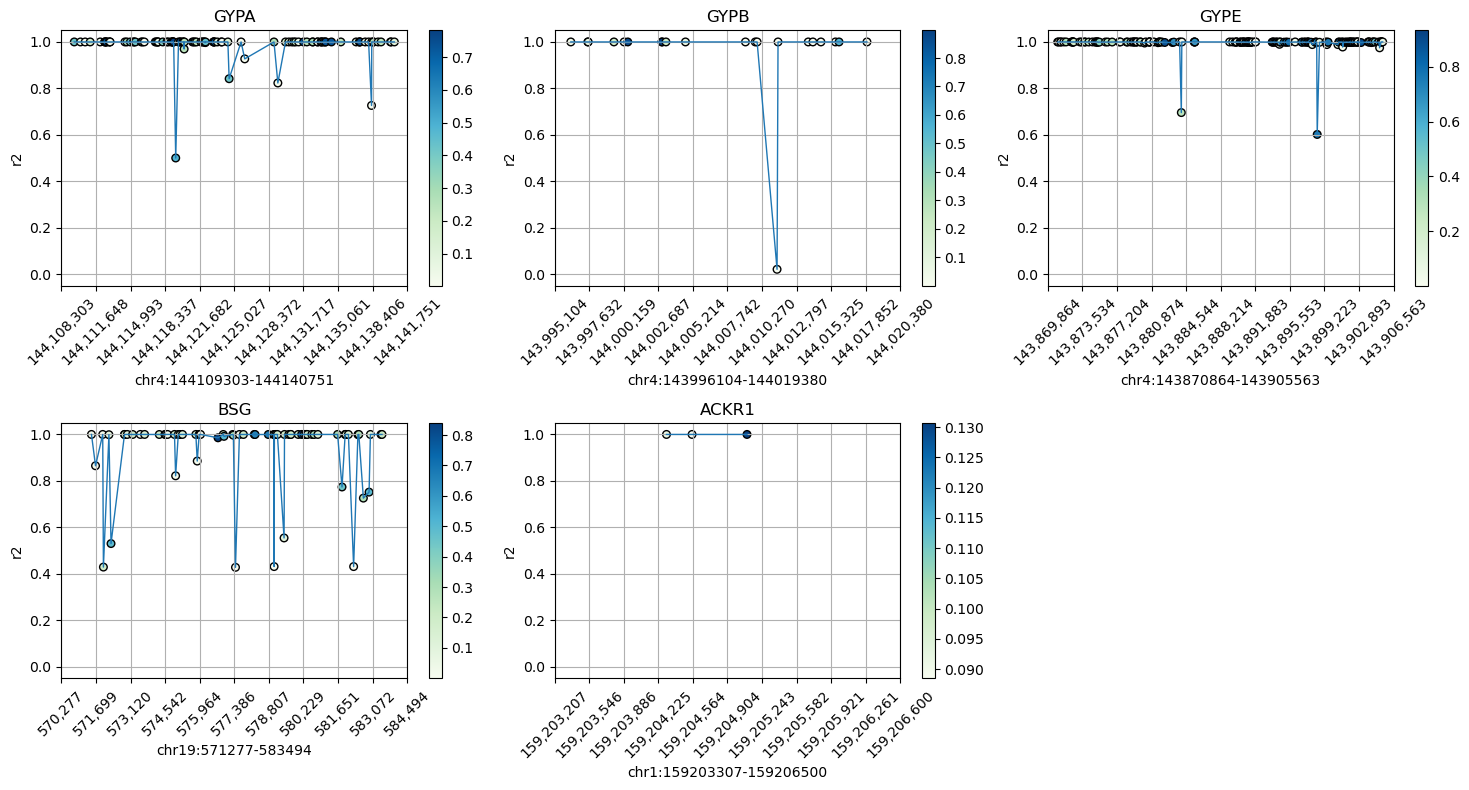

In [4]:
imp_dir = '../archive/GAMCC_old/imputation_comparison/vanilla/lc_oneKG_topmed--hc--snps_gw/impacc/all_samples/by_variant/'
hs = []
for i in CHROMOSOMES_ALL:
    t = pd.read_csv(imp_dir + 'chr' + str(i) + '.h.tsv', sep = '\t')
    hs.append(t)
h = pd.concat(hs)
h = h[(h[['NRC', 'r2', 'ccd_het', 'ccd_homalt']] != -9.).any(axis = 1)]

nrow = 2
ncol = 3
ngraph = len(regions)
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 8))

for i in range(nrow*ncol):
    row = i // (nrow + 1)
    col = i % ncol
    if i < ngraph:
        c, s, e, t = tuple(regions.loc[i].values)
        lcwgsus.plot_imputation_metric_in_region(h, chr=c, pos=0, start=s, end=e, title=t, show_fig=True, ax=axes[row, col])
    else:
        fig.delaxes(axes[row, col])
        
plt.tight_layout()
plt.show()

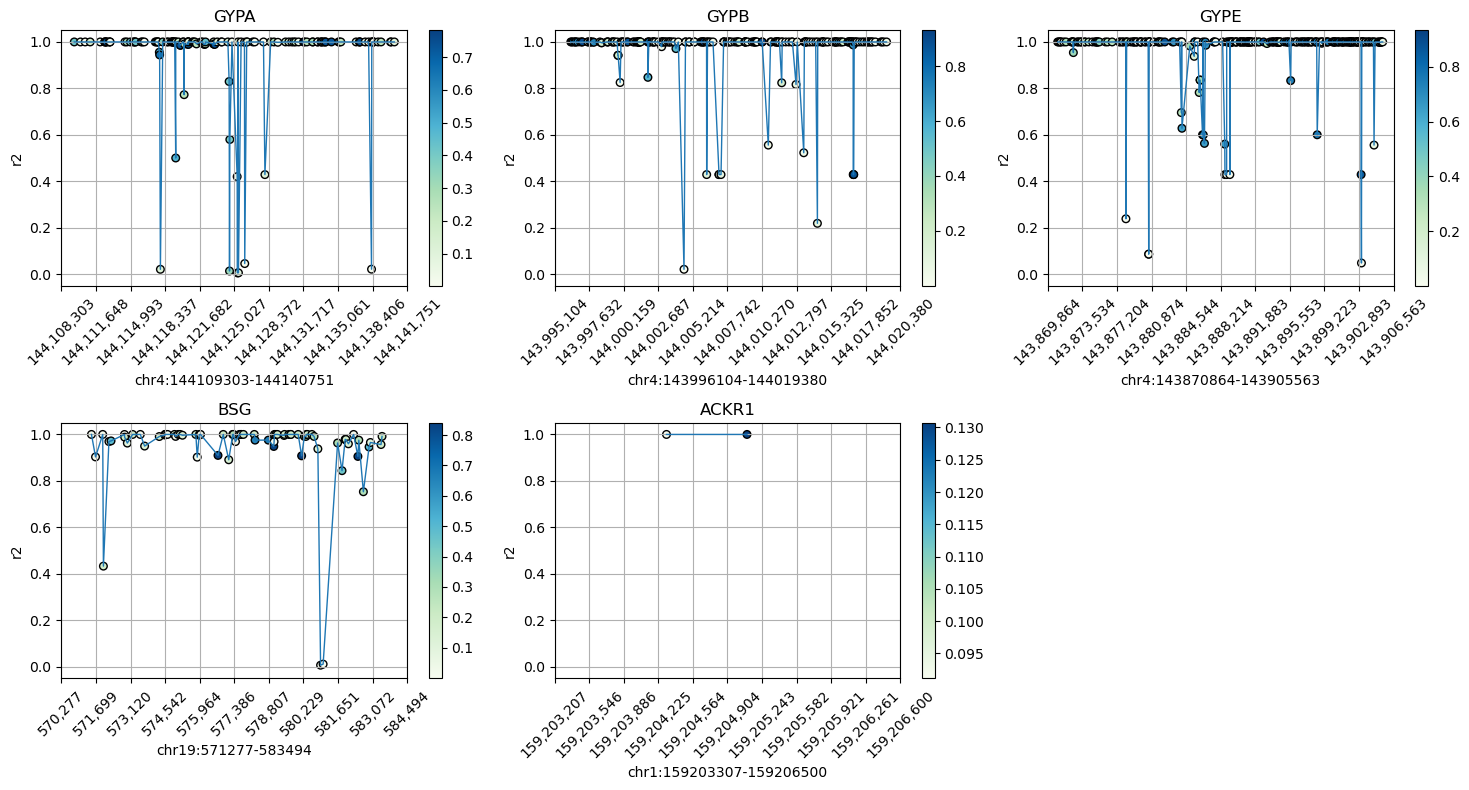

In [5]:
imp_dir = '../archive/GAMCC_old/imputation_comparison/vanilla/lc_oneKG--hc--snps_gw/impacc/all_samples/by_variant/'
hs = []
for i in CHROMOSOMES_ALL:
    t = pd.read_csv(imp_dir + 'chr' + str(i) + '.h.tsv', sep = '\t')
    hs.append(t)
h = pd.concat(hs)
h = h[(h[['NRC', 'r2', 'ccd_het', 'ccd_homalt']] != -9.).any(axis = 1)]

nrow = 2
ncol = 3
ngraph = len(regions)
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 8))

for i in range(nrow*ncol):
    row = i // (nrow + 1)
    col = i % ncol
    if i < ngraph:
        c, s, e, t = tuple(regions.loc[i].values)
        lcwgsus.plot_imputation_metric_in_region(h, chr=c, pos=0, start=s, end=e, title=t, show_fig=True, ax=axes[row, col])
    else:
        fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

# Produce hlatypes for GAMCC

In [128]:
gamcc_hla = lcwgsus.read_hla_direct_sequencing(retain = 'fv', unique_two_field = True)
gamcc_hla = gamcc_hla[['SampleID', 'Locus', 'Two field1', 'Two field2']].reset_index(drop = True)

colnames = ['Sample ID'] + [label for g in HLA_GENES for label in [f'HLA-{g} 1', f'HLA-{g} 2']]
hlatypes = pd.DataFrame(columns = colnames)
for s in gamcc_hla['SampleID'].unique():
    tmp = gamcc_hla[gamcc_hla['SampleID'] == s]
    row = [s] + tmp[['Two field1', 'Two field2']].values.ravel().tolist()
    hlatypes.loc[len(hlatypes)] = row
hlatypes.to_csv('data/hla_direct_sequencing/GAMCC_hlatypes.tsv', sep = '\t', index = False, header = True)

# Filter reads from bam file

In [39]:
gene = 'DQB1'
hla_gene_information = pd.read_csv('/well/band/users/rbx225/software/QUILT_sus/hla_ancillary_files/hla_gene_information.tsv', sep = ' ')
bam = "/well/band/users/rbx225/GAMCC/data/bams/IDT0563.bam"
db = pd.read_csv(f'/well/band/users/rbx225/recyclable_files/hla_reference_files/v3390_aligners/{gene}.ssv', sep = ' ')

reads1 = get_chr6_reads(gene, bam, hla_gene_information, 1000)
# reads2 = get_hla_reads(gene, bam, 1000)
reads1

,ID,flag,chr,pos,map_quality,CIGAR,chr_alt,pos_alt,insert_size,sequence,base_quality,col11,col12,col13,col14,col15,col16,col17,col18,col19
0,A00711:753:HHCG3DSX7:4:2259:9778:30326,83,chr6,32659425,60,151M,=,32659343,-233,CTTCCTTTGCACCATGAACAAAATATATTTGGGTTTCTATCATTTA...,"FF,FF,:FFFFF,F::FFFFFFF:FFFFFF::F,F:FFFFFF::FF...",MC:Z:18M2I131M,MD:Z:9T23C14C9G2T28A6A10C10T30A0,PG:Z:MarkDuplicates,RG:Z:1,NM:i:10,MQ:i:40,AS:i:105,XS:i:74,None
1,A00711:753:HHCG3DSX7:4:2515:19226:9330,163,chr6,32659493,60,151M,=,32659656,314,TGCTGGTTATGCTTTCTTAAAAGTAAAAATTATTCTTGATTGATGT...,FFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,MC:Z:59M1I38M1D53M,MD:Z:22A6A10C10T30A9A2T1T11T10T3C1C24,PG:Z:MarkDuplicates,RG:Z:1,NM:i:12,MQ:i:60,AS:i:91,XS:i:52,None
2,A00711:748:HHFNVDSX7:4:2661:28637:14920,99,chr6,32659506,60,151M,=,32659628,273,TTCTTAAAAGTAAAAATTATTCTTGATTGATGTGACTTGCCAGAAT...,"FFFFFFFFFF::,F,F:F,FF:F:F:FFFFFFF:FFFFF,::F:F:...",MC:Z:87M1I38M1D25M,MD:Z:9A6A10C10T30A9A2T1T11T10T3C1C37,PG:Z:MarkDuplicates,RG:Z:1,NM:i:12,MQ:i:60,AS:i:91,XS:i:47,None
3,A00711:748:HHFNVDSX7:4:2661:28637:14920,147,chr6,32659628,60,87M1I38M1D25M,=,32659506,-273,CCAAACCAGAAGAGAGGCTGGGATATTCTCAGGCCACTGCACTGAG...,FFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFF:FFFFFFFFFFF...,MC:Z:151M,MD:Z:29A6A18T19G4T3A4T22T4C0A6^A4G20,PG:Z:MarkDuplicates,RG:Z:1,NM:i:13,MQ:i:60,AS:i:81,XS:i:62,None
4,A00711:753:HHCG3DSX7:4:2515:19226:9330,83,chr6,32659656,60,59M1I38M1D53M,=,32659493,-314,TCAGGCCACTGCACTGAGCATCAGTATGAAAGAACCATGAATGATG...,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,MC:Z:151M,MD:Z:1A6A18T19G4T3A4T22T4C0A6^A4G25T11C8T1,PG:Z:MarkDuplicates,RG:Z:1,NM:i:16,MQ:i:60,AS:i:72,XS:i:21,None
5,A00711:753:HHCG3DSX7:4:2166:8576:4914,163,chr6,32659807,60,151M,=,32660030,373,CTGGGTCACCTCAAGGTATGTTCCTTCATTCTGCAGTGATTTCCTG...,"FFFFFFFFFFFFFFFFFFFFFFFFFFF,FFFFFFFFFF:FFFF,FF...",MC:Z:39M1I111M,MD:Z:16G34T10A5C61T20,PG:Z:MarkDuplicates,RG:Z:1,NM:i:5,MQ:i:60,AS:i:126,XS:i:58,None
6,A00711:753:HHCG3DSX7:4:2157:14904:6731,99,chr6,32659925,60,151M,=,32660152,378,AGTCAGGTAATGGTTTTCATGTGCTTCTCTTGAGCAGTCTGAGGAG...,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,MC:Z:151M,MD:Z:12T32A25A79,PG:Z:MarkDuplicates,RG:Z:1,NM:i:3,MQ:i:60,AS:i:136,XS:i:55,None
7,A00711:748:HHFNVDSX7:4:2678:20916:25567,99,chr6,32659977,60,151M,=,32660183,357,GAAACAGAAACCCCTTGGGGCCTGAGTAGACGCAGCTGGCCATGCA...,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF...,MC:Z:151M,MD:Z:19A131,PG:Z:MarkDuplicates,RG:Z:1,NM:i:1,MQ:i:60,AS:i:146,XS:i:58,None
8,A00711:753:HHCG3DSX7:4:2166:8576:4914,83,chr6,32660030,60,39M1I111M,=,32659807,-373,AGGCTCTGGGTAAGTGCAGGAAGCAGGGTCACAGCCATCAGCCTCG...,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFF...,MC:Z:151M,MD:Z:11C14A10G5T1G53T16A32C0,PG:Z:MarkDuplicates,RG:Z:1,NM:i:9,MQ:i:60,AS:i:107,XS:i:21,None
9,A00711:753:HHCG3DSX7:4:2157:14904:6731,147,chr6,32660152,60,151M,=,32659925,-378,CACAGGCAGTTGGGAATTCTGGGCAGGGACAAGCAGGCGTTACAGA...,"FFFFFFFFFFFFFFFF,FFFFFFFFFFFFF:::FFFFFFFFFFF:F...",MC:Z:151M,MD:Z:9C17C1T8A1C6G15T29A22C0A0T16T0C1T12,PG:Z:MarkDuplicates,RG:Z:1,NM:i:14,MQ:i:60,AS:i:81,XS:i:49,None


In [30]:
regstart = hla_gene_information[hla_gene_information['Name'] == f'HLA-{gene}']['Start'].values[0]
regend = hla_gene_information[hla_gene_information['Name'] == f'HLA-{gene}']['End'].values[0]

command = f"samtools view {bam} chr6:{regstart-reads_apart_max}-{regend+reads_apart_max}"
reads = subprocess.run(command, shell = True, capture_output = True, text = True).stdout[:-1].split('\n')

reads = [i.split('\t') for i in reads if '##' not in i]
reads = pd.DataFrame(reads)
reads.columns = [
    "ID", "flag", "chr", "pos", "map_quality", "CIGAR", "chr_alt", "pos_alt", "insert_size", "sequence", "base_quality"
] + [f'col{i}' for i in range(11, reads.shape[1])]

reads['pos'] = reads['pos'].astype(int)
reads['pos_alt'] = reads['pos_alt'].astype(int)

mode = reads['sequence'].str.len().mode().values[0]

reads = reads[
    (reads['chr'] == 'chr6') &
    (reads['chr_alt'].isin(['chr6', '='])) &
    (reads['pos_alt'] + reads['sequence'].str.len() >= np.ones(len(reads))*(regstart - reads_apart_max)) & 
    (reads['pos_alt'] <= np.ones(len(reads))*(regend + reads_apart_max)) &
    (reads['sequence'].str.len() == mode)
]

# def check_alternative_mapping(r):
#     alt_map_str = r['col11']
#     invalid_chrs = [f'chr{i}' for i in list(range(1,6)) + list(range(7,23)) + ['X', 'Y', 'MT']]
#     if 'chr' not in alt_map_str:
#         return r
#     else:
#         alt_map_str = alt_map_str.split(':')[-1]
#         for mapping in alt_map_str.split(';'):
#             if mapping != '':
#                 components = mapping.split(',')
#                 if components[0] in invalid_chrs:
#                     r['col11'] = 'REMOVE'
#                     return r
#                 pos = abs(int(components[1]))
#                 if (pos > regend + reads_apart_max) or (pos < regstart - reads_apart_max):
#                     r['col11'] = 'REMOVE'
#                     return r
#         return r
# reads = reads.apply(check_alternative_mapping, axis = 1)
# reads = reads[reads['col11'] != 'REMOVE'].reset_index(drop = True)
reads

,ID,flag,chr,pos,map_quality,CIGAR,chr_alt,pos_alt,insert_size,sequence,...,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20
0,A00711:753:HHCG3DSX7:4:1373:28293:34898,99,chr6,32577978,16,151M,=,32578100,254,CTTAGGGAACAAGGCCTATTTGTTGCAACTCTGGGATCAAACAGAA...,...,"XA:Z:chr6,+32551934,105M46S,7;",MC:Z:17S45M1D13M9D6M2D56M14S,MD:Z:6A2T0G22T25C13T13A0C5C10T1C10C1A0C25A3,PG:Z:MarkDuplicates,RG:Z:1,NM:i:15,MQ:i:7,AS:i:81,XS:i:70,None
1,A00711:753:HHCG3DSX7:4:1373:28293:34898,147,chr6,32578100,7,17S45M1D13M9D6M2D56M14S,=,32577978,-254,AGTACTTGTACTGATGTGTATGTACAAGTAACATATAACTAATAAT...,...,"XA:Z:chr6,-32516748,18S14M5D23M4I16M9D7M1I68M,...",MC:Z:151M,MD:Z:25A5G11A1^C2C0T2T6^ATTGAAAAT6^AC3C12G26A12,PG:Z:MarkDuplicates,RG:Z:1,NM:i:21,MQ:i:16,AS:i:45,XS:i:60,None
2,A00711:753:HHCG3DSX7:4:2278:20862:24064,99,chr6,32578328,40,58M5D93M,=,32578629,429,AATCTGTACAAGTCCTTTGATAATACCATATAATTGAAGTCTCTGG...,...,"XA:Z:chr6,+32552284,58M5D82M1D11M,19;",MC:Z:3S104M5I24M15S,MD:Z:23C2T0G3T15G5C4^TACAC6A8A5A13A1A1G0A24G8C...,PG:Z:MarkDuplicates,RG:Z:1,NM:i:21,MQ:i:51,AS:i:63,XS:i:70,None
4,A00711:753:HHCG3DSX7:4:1307:4951:22717,99,chr6,32578492,45,103M48S,=,32578618,272,CAGTTGTTACAGTCTCTTCTCAGTTTTTATGCATTTCATTTGTAAA...,...,"XA:Z:chr6,+32552449,107M44S,16;",MC:Z:105M5I41M,MD:Z:9T5G19G1C3T5G4G0A12T0T12T1G4G1A13,PG:Z:MarkDuplicates,RG:Z:1,NM:i:14,MQ:i:43,AS:i:33,XS:i:27,None
6,A00711:753:HHCG3DSX7:4:2226:16161:26412,163,chr6,32578539,45,35M5D116M,=,32578870,476,GTTAGGTTTACTTTTTAAATTGACAAGAAAAAATTGTTTATTTATG...,...,"XA:Z:chr6,+32552496,35M5D83M33S,15;",MC:Z:8M1I82M2I55M3S,MD:Z:6A9T10T7^GTATA2A9T0G24G9G0G12C1G12C17C0A8...,PG:Z:MarkDuplicates,RG:Z:1,NM:i:21,MQ:i:55,AS:i:63,XS:i:57,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,A00711:753:HHCG3DSX7:4:1357:32868:14606,147,chr6,32590055,3,11S91M6D40M9S,=,32589760,-432,TCCCTATTGTGAGCCAGCTCTGAGCTGGTCAGTGATGTGTTCACAA...,...,"XA:Z:chr6,-32530528,102M8D49M,19;",MC:Z:48M1I102M,MD:Z:11T64C2C9G1^GTGAGT4G0T15G18,PG:Z:MarkDuplicates,RG:Z:1,NM:i:13,MQ:i:3,AS:i:84,XS:i:86,None
129,A00711:748:HHFNVDSX7:4:1314:13847:19899,163,chr6,32590150,60,5S144M2S,=,32590250,248,TGAGCGTGTGAGTGTGTTTAGGAGTAAAGGAGATGGAGGGAACATG...,...,"XA:Z:chr6,+32530631,55M1I92M3S,8;chr6,+3247393...",MC:Z:75M3I73M,MD:Z:42C0C10A35A23G29,PG:Z:MarkDuplicates,RG:Z:1,NM:i:5,MQ:i:40,AS:i:119,XS:i:105,None
130,A00711:753:HHCG3DSX7:4:2562:9570:32784,99,chr6,32590208,21,117M3I31M,=,32590401,349,CTTTAATCTGGTCCTTATTGCACCATATCTTAATGTCGTAGATTTG...,...,"XA:Z:chr6,+32473988,151M,9;chr6,+32530693,151M...",MC:Z:61M4D25M2D4M1I60M,MD:Z:36T19G29A8C11C3A36,PG:Z:MarkDuplicates,RG:Z:1,NM:i:9,MQ:i:21,AS:i:109,XS:i:110,None
131,A00711:748:HHFNVDSX7:4:1314:13847:19899,83,chr6,32590250,40,75M3I73M,=,32590150,-248,TTTGGGAAAATTACTTCATGTCTCACAGTTGAAATGAAGGCACCGG...,...,"XA:Z:chr6,-32474030,151M,12;chr6,-32530735,151...",MC:Z:5S144M2S,MD:Z:14G29A0T11T7C3A31C6T0C10A27,PG:Z:MarkDuplicates,RG:Z:1,NM:i:13,MQ:i:60,AS:i:89,XS:i:91,None


# Comparing GAMCC HLA with GGVP

In [2]:
def extract_smallest_allele(r):
    if '/' in r['allele']:
        allele_string = r['allele']
        alleles = allele_string.split('/')
        smallest_numeric_value = None
        one = alleles[0].split(':')[0]
        for allele in alleles:
            parts = allele.split(':')
            if len(parts) == 2 and parts[1].isdigit():
                numeric_value = int(parts[1])
                if smallest_numeric_value is None or numeric_value < smallest_numeric_value:
                    smallest_numeric_value = numeric_value
                    two = parts[1]
        r['allele'] =  r['Locus'] + '*' + one + ':' + two
    else:
        r['allele'] = r['Locus'] + '*' +  r['allele']
    return r

def calculate_hla_diversity(freq, label = ''):
    entropy = []
    n_allele = []
#     n_ambiguous = []
    hla_diversity = []
    
    for l in HLA_GENES:
        tmp = freq[freq['Locus'] == l]
        n_allele.append(len(tmp['Two field'].unique()))
        entropy.append(lcwgsus.calculate_shannon_entropy(tmp['Two field'].values))
#         entropy.append(lcwgsus.calculate_shannon_entropy_by_gene(tmp['Two field'].values))
#         n_ambiguous.append(len(tmp[tmp['Two field'].str.contains('/')]))
        hla_diversity.append(1 - (tmp['frequency']**2).sum())

#     summary = pd.DataFrame({'Gene': HLA_GENES, 'Shannon Entropy': entropy, 
#                             'Diversity': hla_diversity,
#                             'Number of distinct alleles': n_allele,
#                            'Number of ambiguous type from SBT': n_ambiguous})
    summary = pd.DataFrame({'Gene': HLA_GENES, f'Shannon Entropy ({label})': entropy, 
                            f'Diversity ({label})': hla_diversity,
                            f'Number of distinct alleles ({label})': n_allele})
    return summary

In [65]:
ggvp = "data/hla_direct_sequencing/GGVP_HLA.tsv"
ggvp = pd.read_csv(ggvp, sep = '\t')

alleles = []
counts = []

for a in ggvp['alleles'].unique():
    tmp = ggvp[ggvp['alleles'] == a]
    alleles.append(a)
    counts.append(tmp['allele_count'].sum())

ggvp = pd.DataFrame({'alleles': alleles, 'count': counts})
ggvp['Locus'] = ggvp['alleles'].str.split('*').str.get(0)
ggvp = ggvp[ggvp['Locus'].isin(HLA_GENES)]
ggvp['Two field'] = ggvp['alleles'].str.split('*').str.get(1)
ggvp = ggvp[['Locus', 'Two field', 'count']]

N = 788
ggvp['frequency'] = ggvp['count']/N

hla = lcwgsus.read_hla_direct_sequencing(retain = 'all')
gamcc = lcwgsus.gather_hla_alleles(hla)
gamcc['allele'] = gamcc['Allele'].str.split('*').str.get(1)
gamcc = gamcc[~gamcc['allele'].str.contains('X')]
gamcc = gamcc.apply(extract_smallest_allele, axis = 1)
gamcc = gamcc['allele'].value_counts().reset_index()
gamcc['Locus'] = gamcc['allele'].str.split('*').str.get(0)
gamcc = gamcc.sort_values(by = ['Locus', 'allele'], ascending = True).reset_index(drop = True).rename(columns = {'allele': 'Two field'})
gamcc = gamcc[['Locus', 'Two field', 'count']]
gamcc['Two field'] = gamcc['Two field'].str.split('*').str.get(1)

N = 500
gamcc['frequency'] = gamcc['count']/N

### oneKG ###
panel = pd.read_csv('/well/band/users/rbx225/GAMCC/results/hla/imputation/ref_panel/auxiliary_files/20181129_HLA_types_full_1000_Genomes_Project_panel.txt', sep = '\t')
region = 'AFR'
population = 'GWD'

if region is not None:
    panel = panel[panel['Region'] == region]
if population is not None:
     panel = panel[panel['Population'] == population]
        
lst = []
for l in HLA_GENES:
    tmp = pd.concat([panel['HLA-' + l + ' 1'], panel['HLA-' + l + ' 2']]).reset_index().rename(columns = {0: 'Two field'}).dropna()
    tmp = tmp[~tmp['Two field'].str.contains('/')]
    tmp = tmp['Two field'].value_counts().reset_index()
    tmp['Locus'] = l
    tmp = tmp[['Locus', 'Two field', 'count']].sort_values(by = 'Two field')
    tmp['frequency'] = tmp['count']/tmp['count'].sum()
    lst.append(tmp)
    
gwd = pd.concat(lst)
### oneKG ###

### oneKG ###
panel = pd.read_csv('/well/band/users/rbx225/GAMCC/results/hla/imputation/ref_panel/auxiliary_files/20181129_HLA_types_full_1000_Genomes_Project_panel.txt', sep = '\t')
region = 'AFR'
population = None

if region is not None:
    panel = panel[panel['Region'] == region]
if population is not None:
     panel = panel[panel['Population'] == population]
        
lst = []
for l in HLA_GENES:
    tmp = pd.concat([panel['HLA-' + l + ' 1'], panel['HLA-' + l + ' 2']]).reset_index().rename(columns = {0: 'Two field'}).dropna()
    tmp = tmp[~tmp['Two field'].str.contains('/')]
    tmp = tmp['Two field'].value_counts().reset_index()
    tmp['Locus'] = l
    tmp = tmp[['Locus', 'Two field', 'count']].sort_values(by = 'Two field')
    tmp['frequency'] = tmp['count']/tmp['count'].sum()
    lst.append(tmp)
    
afr = pd.concat(lst)
### oneKG ###

### oneKG ###
panel = pd.read_csv('/well/band/users/rbx225/GAMCC/results/hla/imputation/ref_panel/auxiliary_files/20181129_HLA_types_full_1000_Genomes_Project_panel.txt', sep = '\t')
region = None
population = None

if region is not None:
    panel = panel[panel['Region'] == region]
if population is not None:
     panel = panel[panel['Population'] == population]
        
lst = []
for l in HLA_GENES:
    tmp = pd.concat([panel['HLA-' + l + ' 1'], panel['HLA-' + l + ' 2']]).reset_index().rename(columns = {0: 'Two field'}).dropna()
    tmp = tmp[~tmp['Two field'].str.contains('/')]
    tmp = tmp['Two field'].value_counts().reset_index()
    tmp['Locus'] = l
    tmp = tmp[['Locus', 'Two field', 'count']].sort_values(by = 'Two field')
    tmp['frequency'] = tmp['count']/tmp['count'].sum()
    lst.append(tmp)
    
oneKG = pd.concat(lst)
### oneKG ###

In [66]:
ggvp_sum = calculate_hla_diversity(ggvp, 'GGVP')
gamcc_sum = calculate_hla_diversity(gamcc, 'GAMCC')
gwd_sum = calculate_hla_diversity(gwd, 'GWD')
afr_sum = calculate_hla_diversity(afr, 'AFR')
onekg_sum = calculate_hla_diversity(oneKG, '1KG')

merged = pd.merge(ggvp_sum, gamcc_sum, on = 'Gene')
merged = pd.merge(merged, onekg_sum, on = 'Gene')
merged = pd.merge(merged, afr_sum, on = 'Gene')
merged = pd.merge(merged, gwd_sum, on = 'Gene')
merged

,Gene,Shannon Entropy (GGVP),Diversity (GGVP),Number of distinct alleles (GGVP),Shannon Entropy (GAMCC),Diversity (GAMCC),Number of distinct alleles (GAMCC),Shannon Entropy (1KG),Diversity (1KG),Number of distinct alleles (1KG),Shannon Entropy (AFR),Diversity (AFR),Number of distinct alleles (AFR),Shannon Entropy (GWD),Diversity (GWD),Number of distinct alleles (GWD)
0,A,4.682131,0.948507,108,3.178054,0.939308,24,4.488636,0.938011,89,3.737670,0.941790,42,3.218876,0.933299,25
1,B,4.595120,0.943228,99,3.737670,0.935480,42,5.117994,0.971772,167,4.262680,0.939538,71,3.555348,0.939130,35
2,C,4.595120,0.921648,99,3.178054,0.909380,24,4.330733,0.936339,76,3.663562,0.897776,39,3.091042,0.913990,22
3,DQB1,3.465736,0.803187,32,2.708050,0.811328,15,3.583519,0.917343,36,3.135494,0.884108,23,2.639057,0.838507,14
4,DRB1,4.356709,0.932793,78,3.178054,0.909224,24,4.406719,0.957247,82,3.784190,0.937799,44,3.135494,0.910521,23


Text(0, 0.5, 'HLA diversity')

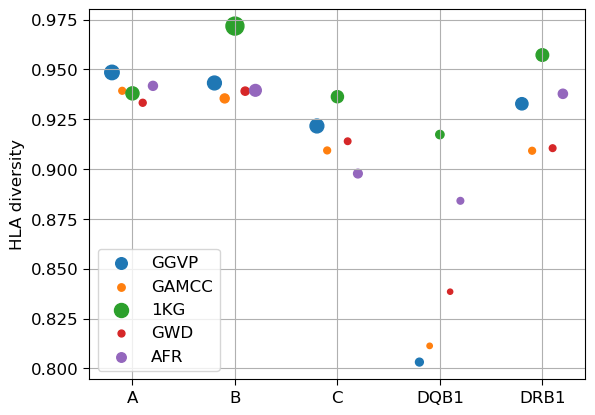

In [48]:
plt.scatter(np.arange(1,6)-0.2, merged['Diversity (GGVP)'], s = merged['Number of distinct alleles (GGVP)'], label = 'GGVP')
plt.scatter(np.arange(1,6)-0.1, merged['Diversity (GAMCC)'], s = merged['Number of distinct alleles (GAMCC)'], label = 'GAMCC')
plt.scatter(np.arange(1,6), merged['Diversity (1KG)'], s = merged['Number of distinct alleles (1KG)'], label = '1KG')
plt.scatter(np.arange(1,6)+0.1, merged['Diversity (GWD)'], s = merged['Number of distinct alleles (GWD)'], label = 'GWD')
plt.scatter(np.arange(1,6)+0.2, merged['Diversity (AFR)'], s = merged['Number of distinct alleles (AFR)'], label = 'AFR')
plt.legend()
ax = plt.gca()
ax.grid(True)
plt.xticks(np.arange(1,6), HLA_GENES)
plt.ylabel('HLA diversity')

In [67]:
gwd.columns = ['Locus', 'Two field', 'count (GWD)', 'frequency (GWD)']
gamcc.columns = ['Locus', 'Two field', 'count (GAMCC)', 'frequency (GAMCC)']
ggvp.columns = ['Locus', 'Two field', 'count (GGVP)', 'frequency (GGVP)']
oneKG.columns = ['Locus', 'Two field', 'count (1KG)', 'frequency (1KG)']
afr.columns = ['Locus', 'Two field', 'count (AFR)', 'frequency (AFR)']

In [68]:
join = 'inner'
alleles = pd.merge(gwd, gamcc, on = ['Locus', 'Two field'], how = join)
alleles = pd.merge(alleles, ggvp, on = ['Locus', 'Two field'], how = join)
alleles = pd.merge(alleles, afr, on = ['Locus', 'Two field'], how = join) 
alleles = pd.merge(alleles, oneKG, on = ['Locus', 'Two field'], how = join).fillna(0)

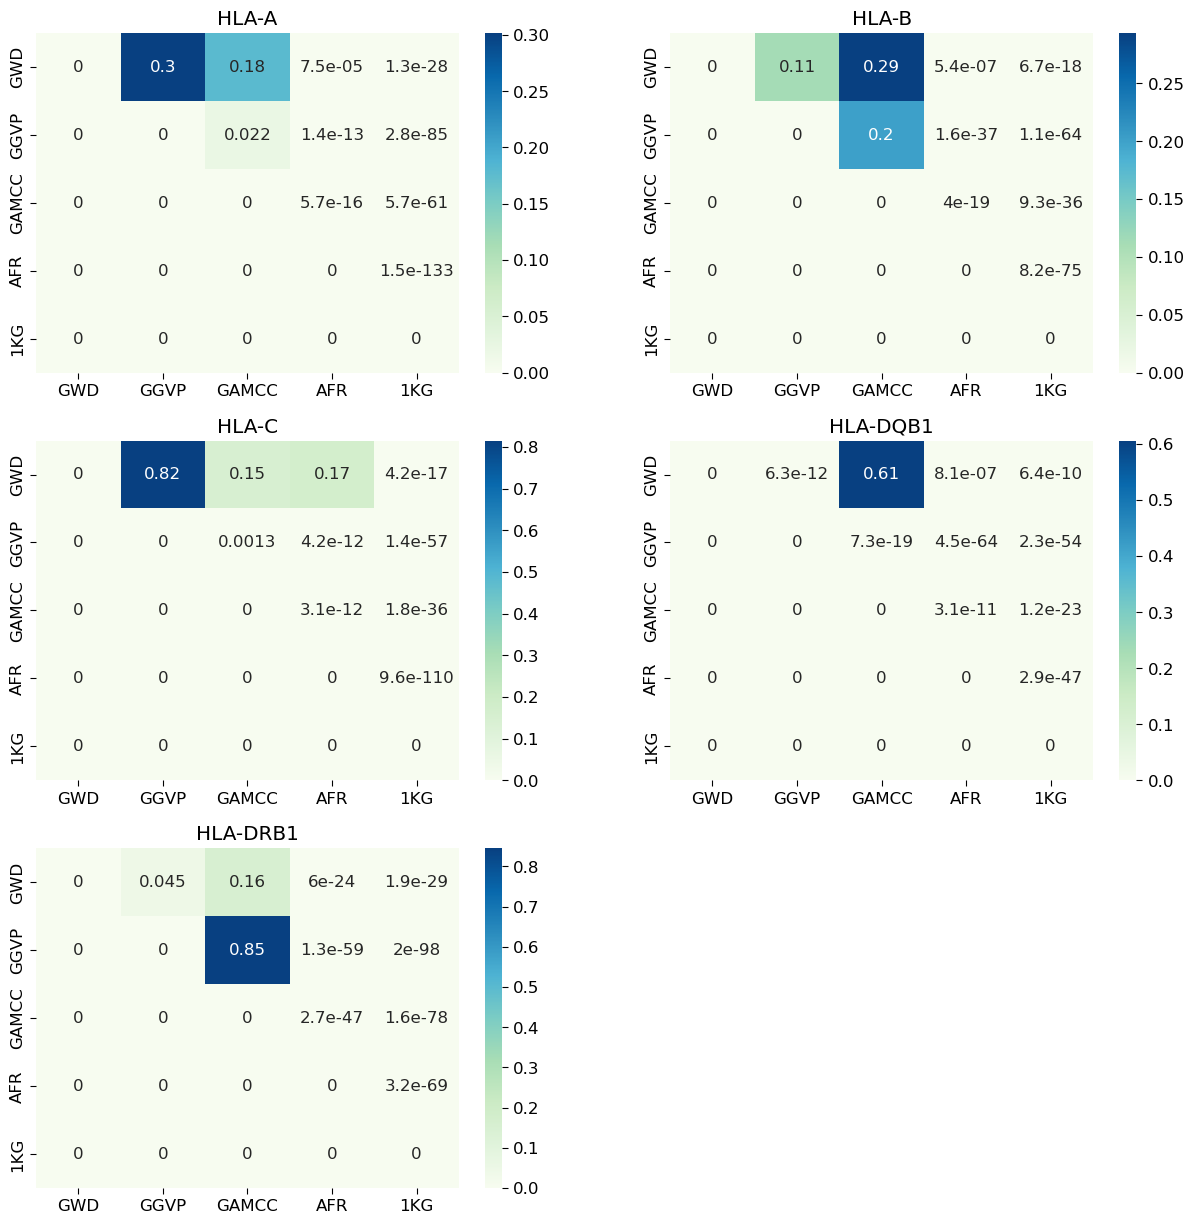

In [69]:
# counts
result = {}
labels = ['GWD', 'GGVP', 'GAMCC', 'AFR', '1KG']
for l in HLA_GENES:
    X = alleles[alleles['Locus'] == l]
    
    X = X[['Two field', 'count (GWD)', 'count (GGVP)', 'count (GAMCC)', 'count (AFR)', 'count (1KG)']].T

    X.columns = X.iloc[0]
    X = X[1:]

    counts_pop1 = list(X.iloc[0, :].values)
    counts_pop2 = list(X.iloc[1, :].values)
    counts_pop3 = list(X.iloc[2, :].values)
    counts_pop4 = list(X.iloc[3, :].values)
    counts_pop5 = list(X.iloc[4, :].values)
    count_lst = [counts_pop1, counts_pop2, counts_pop3, counts_pop4, counts_pop5]
    
    df = pd.DataFrame(index=labels, columns=labels)
    for i in range(4):
        for j in range(i+1, 5):
            contingency_table = np.array([count_lst[i], count_lst[j]])
    # contingency_table = [counts_pop2, counts_pop3]

            res = chi2_contingency(contingency_table, lambda_="log-likelihood")
            df.iloc[i,j] = res.pvalue
    result[l] = df.fillna(0)

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
for i,l in enumerate(HLA_GENES):
    ax = axes[i//2, i%2]
    sns.heatmap(result[l], annot=True, cmap='GnBu', ax = ax)
    ax.set_title(f'HLA-{l}')
fig.delaxes(axes[2,1])

plt.show()

Confidence interval: $$(p_1 - p_2) \pm z*\sqrt{\dfrac{p_1(1-p_1)}{n_1} + \dfrac{p_2(1-p_2)}{n_2}}$$

In [81]:
c1 = alleles[['Locus', 'Two field', 'count (GAMCC)', 'frequency (GAMCC)', 'count (GGVP)', 'frequency (GGVP)']]
c1['z'] = (c1['frequency (GAMCC)'] - c1['frequency (GGVP)'])/np.sqrt(c1['frequency (GAMCC)']*(1-c1['frequency (GAMCC)'])/c1['count (GAMCC)'] + 
           c1['frequency (GGVP)']*(1-c1['frequency (GGVP)'])/c1['count (GGVP)'])
c1[abs(c1['z']) > 1.96]

,Locus,Two field,count (GAMCC),frequency (GAMCC),count (GGVP),frequency (GGVP),z
69,DQB1,02:01,19,0.038,132,0.167513,-2.372307
70,DQB1,03:01,19,0.038,239,0.303299,-5.006419


Text(0, 0.5, 'Allele frequency in GGVP')

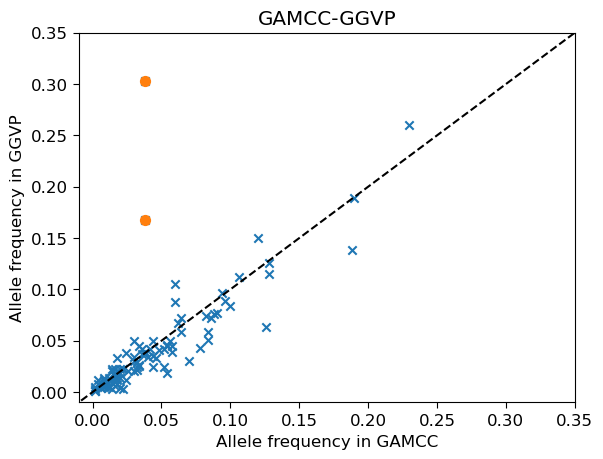

In [118]:
plt.scatter(alleles['frequency (GAMCC)'], alleles['frequency (GGVP)'], marker = 'x')

c1 = alleles[['Locus', 'Two field', 'count (GAMCC)', 'frequency (GAMCC)', 'count (GGVP)', 'frequency (GGVP)']]
c1['z'] = (c1['frequency (GAMCC)'] - c1['frequency (GGVP)'])/np.sqrt(c1['frequency (GAMCC)']*(1-c1['frequency (GAMCC)'])/c1['count (GAMCC)'] + 
           c1['frequency (GGVP)']*(1-c1['frequency (GGVP)'])/c1['count (GGVP)'])
c1 = c1[abs(c1['z']) > 1.96]
plt.scatter(c1['frequency (GAMCC)'], c1['frequency (GGVP)'], marker = 'o', s = 50)

plt.plot(np.linspace(-1, 1, 10), np.linspace(-1, 1, 10), ls = '--', c = 'black')
plt.xlim(-0.01,0.35)
plt.ylim(-0.01,0.35)
plt.title('GAMCC-GGVP')
plt.xlabel('Allele frequency in GAMCC')
plt.ylabel('Allele frequency in GGVP')

Text(0, 0.5, 'Allele frequency in GWD')

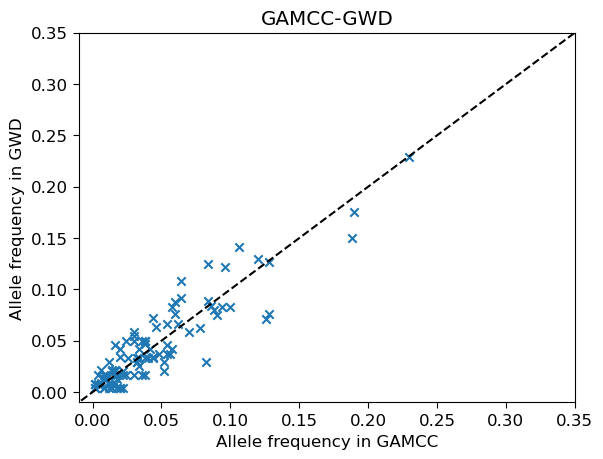

In [119]:
plt.scatter(alleles['frequency (GAMCC)'], alleles['frequency (GWD)'], marker = 'x')

c1 = alleles[['Locus', 'Two field', 'count (GAMCC)', 'frequency (GAMCC)', 'count (GWD)', 'frequency (GWD)']]
c1['z'] = (c1['frequency (GAMCC)'] - c1['frequency (GWD)'])/np.sqrt(c1['frequency (GAMCC)']*(1-c1['frequency (GAMCC)'])/c1['count (GAMCC)'] + 
           c1['frequency (GWD)']*(1-c1['frequency (GWD)'])/c1['count (GWD)'])
c1 = c1[abs(c1['z']) > 1.96]
plt.scatter(c1['frequency (GAMCC)'], c1['frequency (GWD)'], marker = 'o', s = 50)

plt.plot(np.linspace(-1, 1, 10), np.linspace(-1, 1, 10), ls = '--', c = 'black')
plt.xlim(-0.01,0.35)
plt.ylim(-0.01,0.35)
plt.title('GAMCC-GWD')
plt.xlabel('Allele frequency in GAMCC')
plt.ylabel('Allele frequency in GWD')

Text(0, 0.5, 'Allele frequency in AFR')

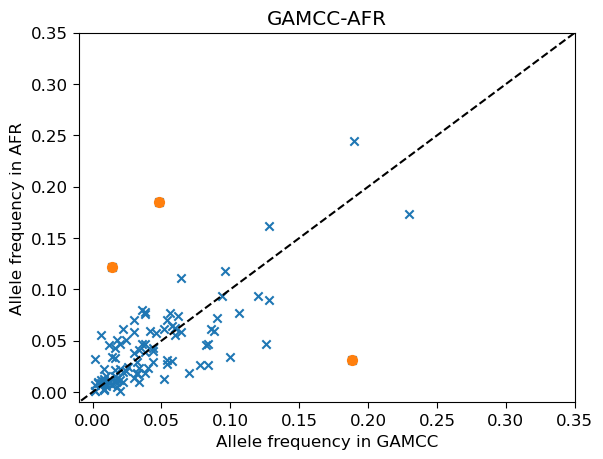

In [120]:
plt.scatter(alleles['frequency (GAMCC)'], alleles['frequency (AFR)'], marker = 'x')

c1 = alleles[['Locus', 'Two field', 'count (GAMCC)', 'frequency (GAMCC)', 'count (AFR)', 'frequency (AFR)']]
c1['z'] = (c1['frequency (GAMCC)'] - c1['frequency (AFR)'])/np.sqrt(c1['frequency (GAMCC)']*(1-c1['frequency (GAMCC)'])/c1['count (GAMCC)'] + 
           c1['frequency (AFR)']*(1-c1['frequency (AFR)'])/c1['count (AFR)'])
c1 = c1[abs(c1['z']) > 1.96]
plt.scatter(c1['frequency (GAMCC)'], c1['frequency (AFR)'], marker = 'o', s = 50)

plt.plot(np.linspace(-1, 1, 10), np.linspace(-1, 1, 10), ls = '--', c = 'black')
plt.xlim(-0.01,0.35)
plt.ylim(-0.01,0.35)
plt.title('GAMCC-AFR')
plt.xlabel('Allele frequency in GAMCC')
plt.ylabel('Allele frequency in AFR')

In [31]:
hla = lcwgsus.read_hla_direct_sequencing()
hla_alleles_df = lcwgsus.gather_hla_alleles(hla)

summary = lcwgsus.calculate_hla_entropy(hla_alleles_df)
summary

,Gene,Shannon Entropy,Number of distinct alleles,Number of ambiguous type from SBT
0,A,2.936754,25,0
1,B,3.103069,42,0
2,C,2.694756,25,0
3,DQB1,2.228746,23,294
4,DRB1,2.741211,31,90


# HLA imputation comparison

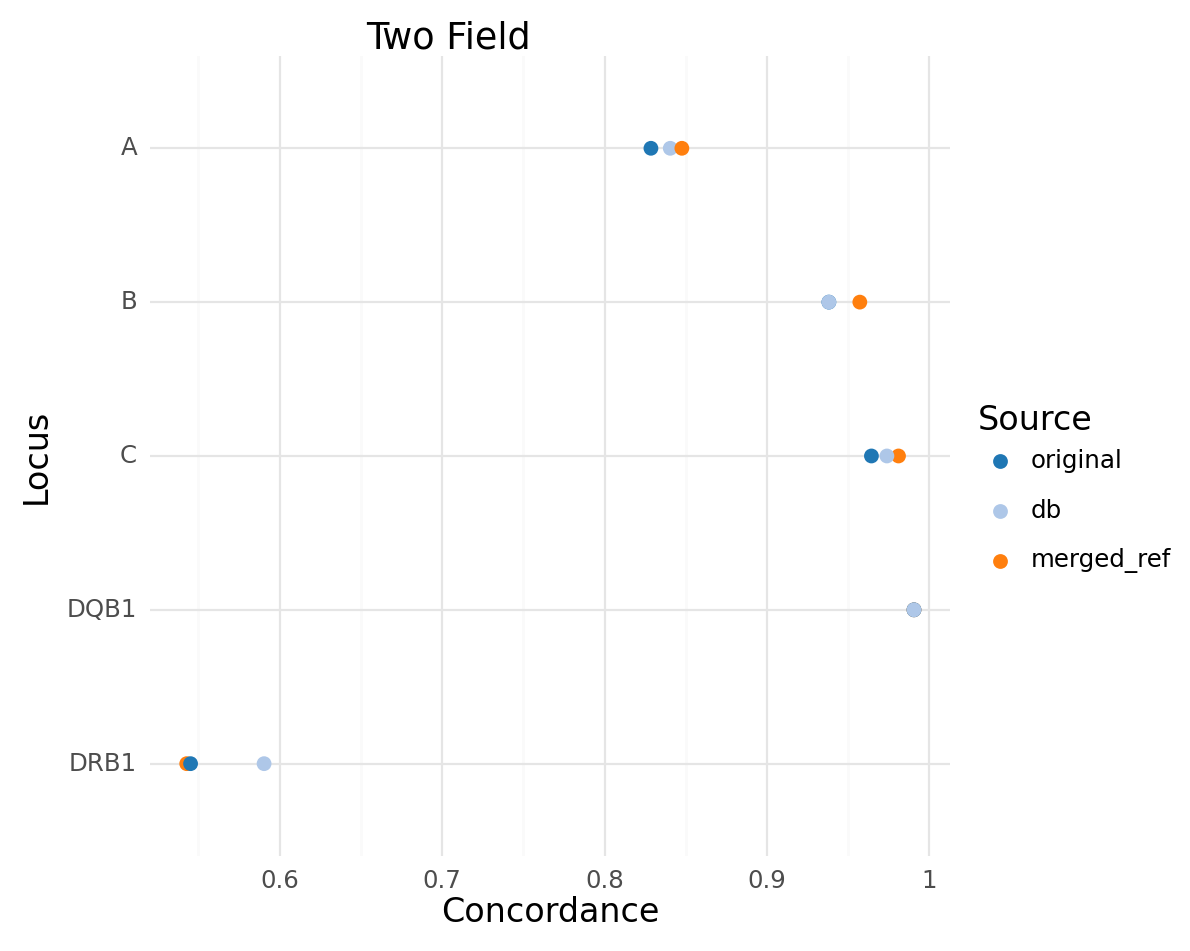

In [11]:
hla = lcwgsus.read_hla_direct_sequencing(retain = 'fv')

hla_dirs = ['/well/band/users/rbx225/GAMCC/results/hla/imputation/batches_archived/', 
                  '/well/band/users/rbx225/GAMCC/results/hla/server/chip_vanilla/chr6.dose.vcf.gz',
                  '/well/band/users/rbx225/GAMCC/results/hla/imputation/QUILT_HLA_result_db/',
                  '/well/band/users/rbx225/GAMCC/results/hla/imputation/QUILT_HLA_result_merged_ref/',
                  '/well/band/users/rbx225/GAMCC/results/hla/imputation/QUILT_HLA_result_method/',
                  '/well/band/users/rbx225/GAMCC/results/hla/imputation/QUILT_HLA_result_optimal/',
                  '/well/band/users/rbx225/GAMCC/results/hla/server/lc_mGen0.9/chr6.dose.vcf.gz']
labels =  ['original', 'chip:multiEth', 'db', 'merged_ref', 'method', 'optimal', 'two-stage']

ix = [0,2,3]
hla_dir = [hla_dirs[i] for i in ix]
label = [labels[i] for i in ix]

p,report = lcwgsus.plot_hla_imputation_accuracy(hla, hla_dir, label)
p

In [3]:
db1 = lcwgsus.read_hla_lc_imputation_results(hla_dirs[4], combined = 'combined', recode_two_field = False)
db2 = lcwgsus.read_hla_lc_imputation_results(hla_dirs[4], combined = 'read', recode_two_field = False)
same = 0
for i in range(len(db1)):
    if set(db1.loc[i, ['Two field1', 'Two field2']]) == set(db2.loc[i, ['Two field1', 'Two field2']]):
        same += 1
same

409

In [56]:
db2[db2['Two field1'] == db2['Two field2']]

,SampleID,Locus,One field1,Two field1,One field2,Two field2,prob
0,GAM013489,A,02,02:01,02,02:01,0.000000
2,GAM013489,C,03,03:03,03,03:03,0.000000
5,GAM013627,A,01,01:01,01,01:01,0.000000
8,GAM013627,DQB1,05,05:01,05,05:01,0.000000
10,GAM013795,A,34,34:02,34,34:02,0.000000
...,...,...,...,...,...,...,...
1014,GAM946580,DRB1,10,10:01,10,10:01,0.000000
1030,GAM962501,A,23,23:01,23,23:01,0.000000
1037,GAM967203,C,06,06:02,06,06:02,0.000000
1038,GAM967203,DQB1,02,02:02,02,02:02,-6.091957


In [4]:
compared = lcwgsus.compare_hla_types(hla, lcwgsus.read_hla_lc_imputation_results(hla_dirs[4], combined = 'combined', recode_two_field = False))
hla_report = lcwgsus.generate_hla_imputation_report(compared, 's')
hla_report

,Locus,Concordance,Resolution,Source
0,A,0.833333,One field,s
1,A,0.757143,Two field,s
2,B,0.428571,One field,s
3,B,0.411905,Two field,s
4,C,0.971429,One field,s
5,C,0.938095,Two field,s
6,DQB1,0.945238,One field,s
7,DQB1,0.921429,Two field,s
8,DRB1,0.338095,One field,s
9,DRB1,0.269048,Two field,s


In [5]:
x = compared[compared['Two field match'] == 1]
x[x['Locus'] == 'B']

,SampleID,Locus,One field1,Two field1,One field2,Two field2,One field match,Two field match
1,GAM013489,B,44,44:03,82,82:01,1,1
11,GAM013795,B,53,53:01,53,53:01,1,1
16,GAM015283,B,08,08:01,35,35:01,1,1
41,GAM039584,B,07,07:06,37,37:01,1,1
46,GAM042356,B,08,08:01,56,56:01,1,1
...,...,...,...,...,...,...,...,...
961,GAM892416,B,49,49:01,53,53:01,1,1
1006,GAM942670,B,07,07:02,58,58:01,1,1
1021,GAM951206,B,08,08:01,14,14:02,1,1
1031,GAM962501,B,07,07:06,35,35:01,1,1


In [8]:
sl = pd.read_csv(SAMPLE_LINKER_FILE)
# sl[sl['Seq_Name'] == 'IDT0689']
sl[sl['Chip_Name'] == 'GAM015283']

,Sample_Name,Seq_Name,Chip_Name
93,GM1549,IDT0701,GAM015283


In [3]:
hla = lcwgsus.read_hla_direct_sequencing(retain = 'fv')
hla[hla['SampleID'] == 'GAM032715']

,SampleID,Locus,One field1,Two field1,One field2,Two field2
25,GAM032715,A,01,01:02,23,23:01
26,GAM032715,B,08,08:01,58,58:01
27,GAM032715,C,01,01:02,03,03:02
28,GAM032715,DQB1,03,03:19,04,04:02/04:87
29,GAM032715,DRB1,13,13:04,03,03:02


In [12]:
reads = lcwgsus.read_hla_lc_imputation_results(hla_dirs[4], combined = 'reads', recode_two_field = False)
reads[reads['Two field1'] == reads['Two field2']]

,SampleID,Locus,One field1,Two field1,One field2,Two field2,prob
0,GAM013489,A,02,02:01,02,02:01,0.964072
5,GAM013627,A,01,01:02,01,01:02,0.763405
8,GAM013627,DQB1,05,05:01,05,05:01,0.999996
11,GAM013795,B,53,53:01,53,53:01,0.994621
12,GAM013795,C,04,04:01,04,04:01,0.919027
...,...,...,...,...,...,...,...
1037,GAM967203,C,06,06:02,06,06:02,0.992399
1038,GAM967203,DQB1,02,02:02,02,02:02,0.943932
1039,GAM967203,DRB1,07,07:01,07,07:01,0.485883
1046,GAM975418,B,07,07:02,07,07:02,0.999997


In [31]:
df = pyreadr.read_r('/well/band/users/rbx225/GAMCC/results/hla/imputation/QUILT_HLA_result_method/IDT0689/DQB1/quilt.RDataput.hlaDQB1.RData')
df['all_results']

KeyError: 'all_results'

In [30]:
for k,v in df:
    print(k)

# Check 1KG phasing SNPs with p3

In [7]:
def read_vcf(start, end, phased_vcf, hlatypes, read_from_QUILT = False, subset_vcf_samples = None, sample_linker = None):
    typed_samples = hlatypes['Sample ID'].tolist()
    
    command = "bcftools view -r chr6:" + str(int(start)) + "-" + str(int(end)) + " " + phased_vcf
    if read_from_QUILT:
        command = command + " | bcftools filter -i 'INFO_SCORE > 0.5'"
    if subset_vcf_samples is not None:
        command = command + ' | bcftools view -s ' + subset_vcf_samples

    snp_haps = subprocess.run(command, shell = True, capture_output = True, text = True).stdout[:-1].split('\n')
    snp_haps = [i.split('\t') for i in snp_haps if '##' not in i]
    snp_haps = pd.DataFrame(snp_haps)
    snp_haps.columns = snp_haps.iloc[0]  # Set the first row as the header
    snp_haps = snp_haps[1:].reset_index(drop = True)
    
    ## Remove this renaming bit later:
    if sample_linker is not None:
        renamed_cols = snp_haps.columns[:9].tolist()
        for s in subset_vcf_samples.split(','):
            renamed_cols.append(sample_linker[s])
        snp_haps.columns = renamed_cols
        for c in snp_haps.columns[9:]: # So only retain GT field, assume it is always the first but later clean vcf first before putting in to phasing
            snp_haps[c] = snp_haps[c].str.split(':').str.get(0) 
    ## End of removal

    retained_samples = snp_haps.columns.intersection(typed_samples).tolist()

    snp_haps = snp_haps.drop(columns = ['#CHROM', 'ID', 'QUAL', 'FILTER', 'FORMAT'])
    snp_haps = snp_haps[(snp_haps['REF'].str.len() == 1) & (snp_haps['ALT'].str.len() == 1)]
    # Test new
    snp_haps = snp_haps.drop_duplicates(subset='POS', keep=False)
    # End of test new
    snp_haps = snp_haps.rename(columns = {'POS': 'pos', 'REF': 'ref', 'ALT': 'alt'})
    snp_haps['snp'] = (snp_haps['pos'].astype(str) + snp_haps['ref'] + snp_haps['alt']).values
    snp_haps['pos'] = snp_haps['pos'].astype(int)
#     snp_haps = snp_haps[['snp', 'pos', 'ref', 'alt'] + retained_samples]
    snp_haps = snp_haps[['snp', 'pos', 'ref', 'alt', 'INFO']]
    return snp_haps

In [6]:
hlatypes = pd.read_csv('results/hla/imputation/ref_panel/auxiliary_files/20181129_HLA_types_full_1000_Genomes_Project_panel.txt', sep = '\t')
p3 = read_vcf(start = 32579091,
                  end = 32589742,
                  phased_vcf = '/well/band/users/rbx225/recyclable_files/ref_panels/oneKG_phase3_b38/oneKG.chr6.vcf.gz', 
                  hlatypes = hlatypes)
p3

,snp,pos,ref,alt,INFO
0,32579467AG,32579467,A,G,AC=1;AN=5096;DP=6729;AF=0;EAS_AF=0;EUR_AF=0;AF...
1,32579779GC,32579779,G,C,AC=1;AN=5096;DP=14200;AF=0;EAS_AF=0;EUR_AF=0;A...
3,32581144AG,32581144,A,G,AC=163;AN=5096;DP=13524;AF=0.03;EAS_AF=0;EUR_A...
4,32582082TA,32582082,T,A,AC=2;AN=5096;DP=12643;AF=0;EAS_AF=0;EUR_AF=0;A...
5,32583204GC,32583204,G,C,AC=597;AN=5096;DP=3913;AF=0.12;EAS_AF=0.03;EUR...
...,...,...,...,...,...
73,32589122GA,32589122,G,A,AC=487;AN=5096;DP=11277;AF=0.1;EAS_AF=0.15;EUR...
74,32589125GC,32589125,G,C,AC=492;AN=5096;DP=11176;AF=0.1;EAS_AF=0.15;EUR...
75,32589148TC,32589148,T,C,AC=299;AN=5096;DP=11457;AF=0.06;EAS_AF=0.03;EU...
76,32589187CA,32589187,C,A,AC=179;AN=5096;DP=7510;AF=0.04;EAS_AF=0.11;EUR...


In [8]:
hlatypes = pd.read_csv('results/hla/imputation/ref_panel/auxiliary_files/20181129_HLA_types_full_1000_Genomes_Project_panel.txt', sep = '\t')
quilt = read_vcf(start = 32579091,
                  end = 32589742,
                  phased_vcf = 'data/ref_panel/oneKG_30x/oneKG.chr6.vcf.gz', 
                  hlatypes = hlatypes)
quilt['VQSR'] = quilt['INFO'].str.extract( 'VQSLOD' + '=([^;]+)' ).astype(float)
# quilt = quilt[quilt['VQSR'] > 0]
quilt

,snp,pos,ref,alt,INFO,VQSR
0,32579157CA,32579157,C,A,AC=15;AC_AFR=0;AC_AMR=6;AC_EAS=7;AC_EUR=2;AC_H...,-3.344
1,32579162CG,32579162,C,G,AC=14;AC_AFR=0;AC_AMR=6;AC_EAS=6;AC_EUR=2;AC_H...,-2.698
2,32579175GA,32579175,G,A,AC=212;AC_AFR=65;AC_AMR=19;AC_EAS=33;AC_EUR=15...,-1.642
3,32579186GA,32579186,G,A,AC=214;AC_AFR=65;AC_AMR=19;AC_EAS=33;AC_EUR=15...,-1.939
4,32579286AG,32579286,A,G,AC=215;AC_AFR=65;AC_AMR=18;AC_EAS=33;AC_EUR=16...,-5.514
...,...,...,...,...,...,...
835,32589651TC,32589651,T,C,AC=399;AC_AFR=236;AC_AMR=41;AC_EAS=40;AC_EUR=5...,-9.527
836,32589681AC,32589681,A,C,AC=0;AC_AFR=0;AC_AMR=0;AC_EAS=0;AC_EUR=0;AC_He...,-10.800
837,32589684AG,32589684,A,G,AC=9;AC_AFR=2;AC_AMR=0;AC_EAS=2;AC_EUR=3;AC_He...,-3.264
838,32589688GA,32589688,G,A,AC=7;AC_AFR=1;AC_AMR=0;AC_EAS=2;AC_EUR=2;AC_He...,-3.236


In [10]:
pd.merge(p3, quilt, on = ['pos'], how = 'inner')

,snp_x,pos,ref_x,alt_x,INFO_x,snp_y,ref_y,alt_y,INFO_y,VQSR
0,32581144AG,32581144,A,G,AC=163;AN=5096;DP=13524;AF=0.03;EAS_AF=0;EUR_A...,32581144AG,A,G,AC=131;AC_AFR=80;AC_AMR=36;AC_EAS=1;AC_EUR=13;...,-1.9930
1,32582082TA,32582082,T,A,AC=2;AN=5096;DP=12643;AF=0;EAS_AF=0;EUR_AF=0;A...,32582082TA,T,A,AC=3;AC_AFR=0;AC_AMR=0;AC_EAS=3;AC_EUR=0;AC_He...,-2.4690
2,32583519AT,32583519,A,T,AC=198;AN=5096;DP=4840;AF=0.04;EAS_AF=0.08;EUR...,32583519AT,A,T,AC=197;AC_AFR=35;AC_AMR=50;AC_EAS=73;AC_EUR=31...,-3.1990
3,32584488CG,32584488,C,G,AC=54;AN=5096;DP=23865;AF=0.01;EAS_AF=0.04;EUR...,32584488CG,C,G,AC=464;AC_AFR=171;AC_AMR=33;AC_EAS=131;AC_EUR=...,-1.2920
4,32584569CT,32584569,C,T,AC=64;AN=5096;DP=18673;AF=0.01;EAS_AF=0.05;EUR...,32584569CT,C,T,AC=2116;AC_AFR=771;AC_AMR=282;AC_EAS=354;AC_EU...,2.2400
5,32584778CT,32584778,C,T,AC=106;AN=5096;DP=11392;AF=0.02;EAS_AF=0.07;EU...,32584778CT,C,T,AC=150;AC_AFR=0;AC_AMR=0;AC_EAS=100;AC_EUR=0;A...,-2.7260
6,32585757AT,32585757,A,T,AC=37;AN=5096;DP=11481;AF=0.01;EAS_AF=0.03;EUR...,32585757AT,A,T,AC=27;AC_AFR=0;AC_AMR=0;AC_EAS=27;AC_EUR=0;AC_...,-1.0280
7,32588028AG,32588028,A,G,AC=614;AN=5096;DP=13435;AF=0.12;EAS_AF=0.12;EU...,32588028AG,A,G,AC=4792;AC_AFR=1416;AC_AMR=769;AC_EAS=867;AC_E...,-0.9688
8,32588337CT,32588337,C,T,AC=58;AN=5096;DP=16129;AF=0.01;EAS_AF=0.01;EUR...,32588337CT,C,T,AC=1367;AC_AFR=469;AC_AMR=156;AC_EAS=238;AC_EU...,-1.0230
9,32589122GA,32589122,G,A,AC=487;AN=5096;DP=11277;AF=0.1;EAS_AF=0.15;EUR...,32589122GA,G,A,AC=211;AC_AFR=31;AC_AMR=43;AC_EAS=119;AC_EUR=8...,-8.5430


In [51]:
# hla_gene_information = pd.read_csv('/well/band/users/rbx225/software/QUILT_sus/hla_ancillary_files/hla_gene_information.tsv', sep = ' ')
# samples = lcwgsus.read_tsv_as_lst('/well/band/users/rbx225/GAMCC/data/sample_tsvs/fv_gm_names.tsv')

# hla = lcwgsus.read_hla_direct_sequencing(retain = 'fv')
# hla = hla.drop(columns = ['One field1', 'One field2'])

# def keep_first_allele(a):
#     if '/' in a:
#         alleles = a.split('/')
#         onefield = alleles[0].split(':')[0]
#         second_fields = [
#             int(re.match(r"(\d+)", allele.split(':')[1]).group(1)) 
#             for allele in alleles
#         ]
#         smallest_second_field = min(second_fields)
#         return f"{onefield}:{smallest_second_field:02d}"
#     elif 'XX' in a:
#         return '-9'
#     else:
#         return a

# hla['Two field1'] = hla['Two field1'].apply(keep_first_allele)
# hla['Two field2'] = hla['Two field2'].apply(keep_first_allele)

# colnames = ['Sample ID'] + [label for g in HLA_GENES for label in [f'HLA-{g} 1', f'HLA-{g} 2']]
# hlatypes = pd.DataFrame(columns = colnames)
# for s in hla['SampleID'].unique():
#     tmp = hla[hla['SampleID'] == s]
#     row = [s] + tmp[['Two field1', 'Two field2']].values.ravel().tolist()
#     hlatypes.loc[len(hlatypes)] = row
    
# sl = pd.read_csv(SAMPLE_LINKER_FILE)
# sl = {k:v for k, v in zip(sl['Chip_Name'], sl['Sample_Name'])}
# hlatypes['Sample ID'] = hlatypes['Sample ID'].apply(lambda x: sl[x])

# phased_vcf = "/well/band/users/rbx225/GAMCC/results/imputation/vcfs/malariaGen_v1_b38/quilt.chr6.vcf.gz"

# # phased_vcf = "/well/band/users/rbx225/GAMCC/results/two-stage-imputation/vanilla/malariaGen_v1_b38_topmed/emp_vcf/chr6.empiricalDose.vcf.gz"

# start = 25000000
# end = 34000000

# command = f"bcftools view -s {','.join(samples)} -r chr6:" + str(int(start)) + "-" + str(int(end)) + " " + phased_vcf
# vcf = subprocess.run(command, shell = True, capture_output = True, text = True).stdout[:-1].split('\n')
# vcf = [i.split('\t') for i in vcf if '##' not in i]
# vcf = pd.DataFrame(vcf)
# vcf.columns = vcf.iloc[0]  # Set the first row as the header
# vcf = vcf[1:].reset_index(drop = True)
# vcf['POS'] = vcf['POS'].astype(int)

# distinct_alleles = {}
# for g in HLA_GENES:
#     alleles = np.append(hlatypes[f'HLA-{g} 1'].astype(str).to_numpy(), hlatypes[f'HLA-{g} 2'].astype(str).to_numpy())
#     alleles = np.unique(alleles)
#     alleles = alleles[alleles != 'nan']
#     alleles = alleles[alleles != '-9']
#     distinct_alleles[g] = alleles

# for g in HLA_GENES:
#     r = hla_gene_information[hla_gene_information['Name'] == f'HLA-{g}']
#     start = r['Start'].values[0]
#     all_snp_pos = vcf['POS'].tolist()
#     position = start
#     n_alleles = 0

#     while n_alleles < len(distinct_alleles[g]):
#         if position in all_snp_pos:
#             pass
#         else:
#             twofield = distinct_alleles[g][n_alleles]
#             common_cols = ['chr6', position, f'HLA_{g}*{twofield}', 'T', 'A', '.', '.', 'TYPED', 'GT']
#             allele1 = (hlatypes[f'HLA-{g} 1'] == twofield).astype(int).values
#             allele2 = (hlatypes[f'HLA-{g} 2'] == twofield).astype(int).values

#             gts = [f'{a1}/{a2}' for a1, a2 in zip(allele1, allele2)]
#             vcf.loc[len(vcf)] = common_cols + gts
#             n_alleles += 1
#         position += 1

# vcf = vcf.sort_values(by = 'POS', ascending = True).reset_index(drop = True)

# metadata = lcwgsus.read_metadata(phased_vcf, filetype = 'gzip', comment = '#', new_cols = None)
# metadata[-1] = '\t'.join(vcf.columns) + '\n'
# lcwgsus.save_vcf(vcf,
#              metadata,
#              rezip = True,
#              prefix='',
#              outdir='/well/band/users/rbx225/GAMCC/results/phasing/HLA_GAMCC_BEAGLE/',
#              save_name='unphased.GAMCC.chr6.vcf.gz'
#              )

In [15]:
gamcc_hla = lcwgsus.read_hla_direct_sequencing(retain = 'fv', unique_two_field = False)
gamcc_hla = gamcc_hla[['SampleID', 'Locus', 'Two field1', 'Two field2']].reset_index(drop = True)

colnames = ['Sample ID'] + [label for g in HLA_GENES for label in [f'HLA-{g} 1', f'HLA-{g} 2']]
hlatypes = pd.DataFrame(columns = colnames)
for s in gamcc_hla['SampleID'].unique():
    tmp = gamcc_hla[gamcc_hla['SampleID'] == s]
    row = [s] + tmp[['Two field1', 'Two field2']].values.ravel().tolist()
    hlatypes.loc[len(hlatypes)] = row
subset_vcf_samples = lcwgsus.read_tsv_as_lst('/well/band/users/rbx225/GAMCC/data/sample_tsvs/fv_gm_names.tsv')
subset_vcf_samples = ','.join(subset_vcf_samples)
sample_linker = pd.read_csv('/well/band/users/rbx225/GAMCC/' + SAMPLE_LINKER_FILE)
sample_linker = {k:v for k, v in zip(sample_linker['Sample_Name'], sample_linker['Chip_Name'])}

topmed = read_vcf(start = 25000000,
                  end = 26000000,
                  phased_vcf = 'results/two-stage-imputation/vanilla/malariaGen_v1_b38_topmed/emp_vcf/chr6.empiricalDose.vcf.gz', 
                  hlatypes = hlatypes,
                  read_from_QUILT = False, 
                  subset_vcf_samples = subset_vcf_samples, 
                  sample_linker = sample_linker)
topmed

,snp,pos,ref,alt,GAM841720,GAM791624,GAM153980,GAM314862,GAM420793,GAM573692,...,GAM786925,GAM340189,GAM382597,GAM039584,GAM951638,GAM620314,GAM975418,GAM270698,GAM042356,GAM592361
0,25000645TG,25000645,T,G,1|0,0|0,0|1,0|0,0|1,0|0,...,0|0,0|0,1|1,0|0,0|0,1|0,0|0,1|1,0|0,0|0
1,25002812CT,25002812,C,T,0|1,0|0,0|0,0|0,0|0,1|0,...,0|1,0|1,0|0,1|1,0|1,0|1,0|0,0|0,0|1,0|1
2,25006298AG,25006298,A,G,1|0,0|0,0|1,1|0,0|1,0|0,...,0|0,0|0,1|1,0|0,0|0,1|0,0|0,1|1,0|0,0|0
3,25006557AG,25006557,A,G,1|0,1|1,1|1,1|1,1|1,0|1,...,1|0,1|0,1|1,0|0,1|0,1|0,1|1,1|1,1|0,1|0
4,25007588TC,25007588,T,C,0|0,1|0,0|0,0|0,1|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1302,25996445GA,25996445,G,A,1|1,0|0,1|1,1|1,1|1,1|1,...,1|1,0|1,1|1,1|0,1|1,1|1,1|1,0|0,0|1,1|1
1303,25996574AG,25996574,A,G,0|0,0|0,0|0,0|1,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
1304,25997230CT,25997230,C,T,0|0,0|0,0|0,0|1,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
1305,25998311GA,25998311,G,A,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0


In [10]:
quilt = read_vcf(start = 25000000,
                  end = 26000000,
                  phased_vcf = 'results/imputation/vcfs/malariaGen_v1_b38/quilt.chr6.vcf.gz', 
                  hlatypes = hlatypes,
                  read_from_QUILT = True, 
                  subset_vcf_samples = subset_vcf_samples, 
                  sample_linker = sample_linker)
quilt

,snp,pos,ref,alt,GAM841720,GAM791624,GAM153980,GAM314862,GAM420793,GAM573692,...,GAM786925,GAM340189,GAM382597,GAM039584,GAM951638,GAM620314,GAM975418,GAM270698,GAM042356,GAM592361
0,25000046TA,25000046,T,A,1|0,0|0,0|0,0|0,0|1,0|0,...,0|0,0|0,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0
1,25000088CT,25000088,C,T,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
2,25000090CT,25000090,C,T,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
3,25000177AG,25000177,A,G,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
4,25000224GA,25000224,G,A,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,1|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,1|0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26649,25999736GA,25999736,G,A,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
26650,25999752AG,25999752,A,G,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
26651,25999798GC,25999798,G,C,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
26652,25999828CT,25999828,C,T,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0


# Aggregate phasing

In [20]:
output = 'results/hla_ref_panel/oneKG_mGenv1/oneKG_mGenv1_HLA_calls.tsv'

for num, gene in enumerate(HLA_GENES):
    direct_phasing = pd.read_csv(f'results/phasing/phased_dfs/oneKG_30x-strict-{gene}.tsv', sep = '\t')

    unphased_df = direct_phasing[pd.isna(direct_phasing[f'HLA-{gene} 1']) & pd.isna(direct_phasing[f'HLA-{gene} 2'])]
    phased_df = direct_phasing[~(pd.isna(direct_phasing[f'HLA-{gene} 1']) & pd.isna(direct_phasing[f'HLA-{gene} 2']))]
    unphased_samples = unphased_df['Sample ID'].tolist()

    beagle_hla = pd.concat([pd.read_csv(f"results/phasing/HLA_1KG_BEAGLE/tmp/beagle_phased_per_sample/{gene}.{s}.1KG.tsv", sep = '\t') for s in unphased_samples])
    beagle_hla = beagle_hla.reset_index(drop = True)

    final_phasing = pd.concat([phased_df, beagle_hla]).sort_values(by = ['Sample ID'])

    unphased_to_check = beagle_hla[beagle_hla.isna().sum(axis=1) == 1]['Sample ID'].tolist()

    hlatypes = pd.read_csv('results/hla/imputation/ref_panel/auxiliary_files/20181129_HLA_types_full_1000_Genomes_Project_panel.txt', sep = '\t')
    hlatypes = hlatypes[hlatypes['Sample ID'].isin(unphased_to_check)][['Sample ID', f'HLA-{gene} 1', f'HLA-{gene} 2']].sort_values(by = 'Sample ID').reset_index(drop = True).fillna('-9')

    for i,s in enumerate(unphased_to_check):
        original_idx = np.where(final_phasing['Sample ID'] == s)[0][0]
        if ('/' in hlatypes.iloc[i, 1]) or ('/' in hlatypes.iloc[i, 2]):
            type1 = hlatypes.iloc[i, 1]
            type2 = hlatypes.iloc[i, 2]
            
            if final_phasing.iloc[original_idx, 1] == type1:
                final_phasing.iloc[original_idx, 2] = type2
            elif final_phasing.iloc[original_idx, 1] == type2:
                final_phasing.iloc[original_idx, 2] = type1
            elif final_phasing.iloc[original_idx, 2] == type1:
                final_phasing.iloc[original_idx, 1] = type2
            elif final_phasing.iloc[original_idx, 2] == type2:
                final_phasing.iloc[original_idx, 1] = type1
            else:
                pass
        else:
            final_phasing.iloc[original_idx, 1] = 'N/A'
            final_phasing.iloc[original_idx, 2] = 'N/A'
    
    if num == 0:
        df = final_phasing
    else:
        df = pd.merge(df, final_phasing, on = 'Sample ID')
df = df.fillna('N/A')
oneKG = df.copy()

In [21]:
sl = pd.read_csv(SAMPLE_LINKER_FILE)
sl = sl[~sl['Sample_Name'].str.contains('mini')]

sl_gam_gm = {k:v for k,v in zip(sl['Chip_Name'], sl['Sample_Name'])}
sl_gm_idt = {k:v for k,v in zip(sl['Sample_Name'], sl['Seq_Name'])}
sl_gam_idt = {k:v for k,v in zip(sl['Chip_Name'], sl['Seq_Name'])}
sl_idt_gm = {k:v for k,v in zip(sl['Seq_Name'], sl['Sample_Name'])}

for num, gene in enumerate(HLA_GENES):
    direct_phasing = pd.read_csv(f'results/phasing/phased_dfs/GAMCC-{gene}.tsv', sep = '\t')
    direct_phasing['Sample ID'] = direct_phasing['Sample ID'].apply(lambda x: sl_gam_idt[x])
    unphased_df = direct_phasing[pd.isna(direct_phasing[f'HLA-{gene} 1']) & pd.isna(direct_phasing[f'HLA-{gene} 2'])]
    phased_df = direct_phasing[~(pd.isna(direct_phasing[f'HLA-{gene} 1']) & pd.isna(direct_phasing[f'HLA-{gene} 2']))]
    unphased_samples = unphased_df['Sample ID'].tolist()
    unphased_samples = [sl_idt_gm[s] for s in unphased_samples]

    beagle_hla = pd.concat([pd.read_csv(f"results/phasing/HLA_GAMCC_BEAGLE/tmp/beagle_phased_per_sample/{gene}.{s}.GAMCC.tsv", sep = '\t') for s in unphased_samples])
    beagle_hla = beagle_hla.reset_index(drop = True)
    beagle_hla['Sample ID'] = beagle_hla['Sample ID'].apply(lambda x: sl_gm_idt[x])

    final_phasing = pd.concat([phased_df, beagle_hla]).sort_values(by = ['Sample ID'])

    unphased_to_check = beagle_hla[beagle_hla.isna().sum(axis=1) == 1]['Sample ID'].tolist()

    hlatypes = pd.read_csv('data/hla_direct_sequencing/GAMCC_hlatypes.tsv', sep = '\t')
    hlatypes['Sample ID'] = hlatypes['Sample ID'].apply(lambda x: sl_gam_idt[x])
    hlatypes = hlatypes[hlatypes['Sample ID'].isin(unphased_to_check)][['Sample ID', f'HLA-{gene} 1', f'HLA-{gene} 2']].sort_values(by = 'Sample ID').reset_index(drop = True).fillna('-9')

    for i,s in enumerate(unphased_to_check):
        original_idx = np.where(final_phasing['Sample ID'] == s)[0][0]
        if ('/' in hlatypes.iloc[i, 1]) or ('/' in hlatypes.iloc[i, 2]):
            type1 = hlatypes.iloc[i, 1]
            type2 = hlatypes.iloc[i, 2]
            
            if final_phasing.iloc[original_idx, 1] == type1:
                final_phasing.iloc[original_idx, 2] = type2
            elif final_phasing.iloc[original_idx, 1] == type2:
                final_phasing.iloc[original_idx, 2] = type1
            elif final_phasing.iloc[original_idx, 2] == type1:
                final_phasing.iloc[original_idx, 1] = type2
            elif final_phasing.iloc[original_idx, 2] == type2:
                final_phasing.iloc[original_idx, 1] = type1
            else:
                pass
        else:
            final_phasing.iloc[original_idx, 1] = 'N/A'
            final_phasing.iloc[original_idx, 2] = 'N/A'
    
    if num == 0:
        df = final_phasing
    else:
        df = pd.merge(df, final_phasing, on = 'Sample ID')
df = df.fillna('N/A')
gamcc = df.copy()

In [27]:
merged = pd.concat([oneKG, gamcc])
merged.to_csv(output, sep = '\t', index = False, header = True)

# Blood group variants

In [12]:
genes = pd.read_csv('data/blood_group_variants/blood_group_genes.tsv', sep = '\t', index_col = False)
genes = genes[genes['Chromosome'] != 'X'].reset_index(drop = True)
genes = genes.iloc[:,[1,2,3,0]]
genes.columns = ['chr', 'start', 'end', 'gene']
genes['chr'] = genes['chr'].astype(int)

variants = pd.read_csv('data/blood_group_variants/blood_group_variants.tsv', sep = '\t', index_col = False)
variants

,chr,pos,ID,ref,alt,MAF
0,11,5227002,rs334,T,A,0.04940
1,11,5227003,rs33930165,C,T,0.01452
2,9,133257521,rs8176719,T,TC,0.30300
3,8,697972,rs1075451,C,T,0.57430


## lc vs chip (N=210)

In [92]:
imp_dir = 'results/imputation_comparison/vanilla/lc_oneKG--chip--typed/impacc/all_samples/by_variant/'
hs = []
cs = [8,9,11]
for i in CHROMOSOMES_ALL:
    t = pd.read_csv(imp_dir + 'chr' + str(i) + '.h.tsv', sep = '\t')
    hs.append(t)
h = pd.concat(hs)
# h = h[(h[['NRC', 'r2', 'ccd_het', 'ccd_homalt']] != -9.).any(axis = 1)]

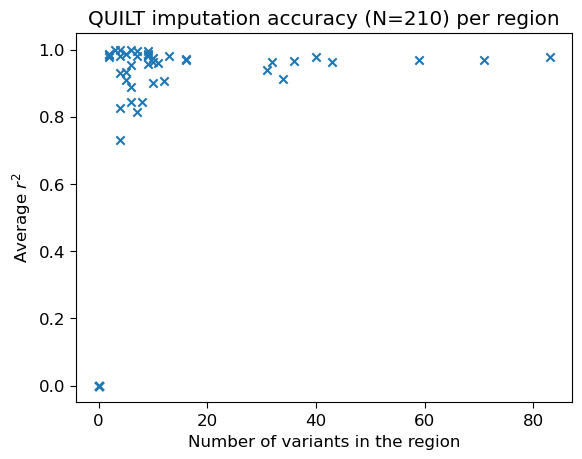

In [93]:
# imp_dir = '../archive/GAMCC_old/imputation_comparison/vanilla/lc_oneKG--hc--snps_gw/impacc/all_samples/by_variant/'
# hs = []
# for i in CHROMOSOMES_ALL:
#     t = pd.read_csv(imp_dir + 'chr' + str(i) + '.h.tsv', sep = '\t')
#     hs.append(t)
# h = pd.concat(hs)
# # h = h[(h[['NRC', 'r2', 'ccd_het', 'ccd_homalt']] != -9.).any(axis = 1)]
# h = h[h['r2'] != -9]

region = genes.copy()

region['r2'] = 0
region['n_variants'] = 0
# region['rho_variants'] = 0 # Density
for i in range(len(genes)):
    c,s,e,t = region.iloc[i, :4]
    tmp = h[h['chr'] == c]
    tmp = tmp[tmp['r2'] != -9]

    df = tmp[(tmp['pos'] < e) & (tmp['pos'] > s)]
    if len(df) == 0:
        pass
    else:
        region.loc[i, 'r2'] = df['r2'].mean()
        region.loc[i, 'n_variants'] = len(df)
#         region['rho_variants'] = 1000*len(df)/(e-s)

plt.scatter(region['n_variants'], region['r2'], marker = 'x')
plt.xlabel('Number of variants in the region')
plt.ylabel('Average $r^2$')
plt.title('QUILT imputation accuracy (N=210) per region')
plt.show()

In [94]:
region.sort_values(by = 'r2')

,chr,start,end,gene,r2,n_variants
23,6,31982057,32002681,C4A,0.000000,0
28,1,159203307,159206500,ACKR1,0.000000,0
7,1,25272393,25330445,RHD,0.000000,0
16,1,3772749,3775982,SMIM1,0.000000,0
10,6,32014795,32035418,C4B,0.000000,0
14,19,10286955,10288522,ICAM4,0.000000,0
13,7,30911853,30925517,AQP1,0.731524,4
4,19,44809071,44821421,BCAM,0.813823,7
20,19,48748011,48755390,FUT1,0.824941,4
18,17,44248390,44268141,SLC4A1,0.843631,6


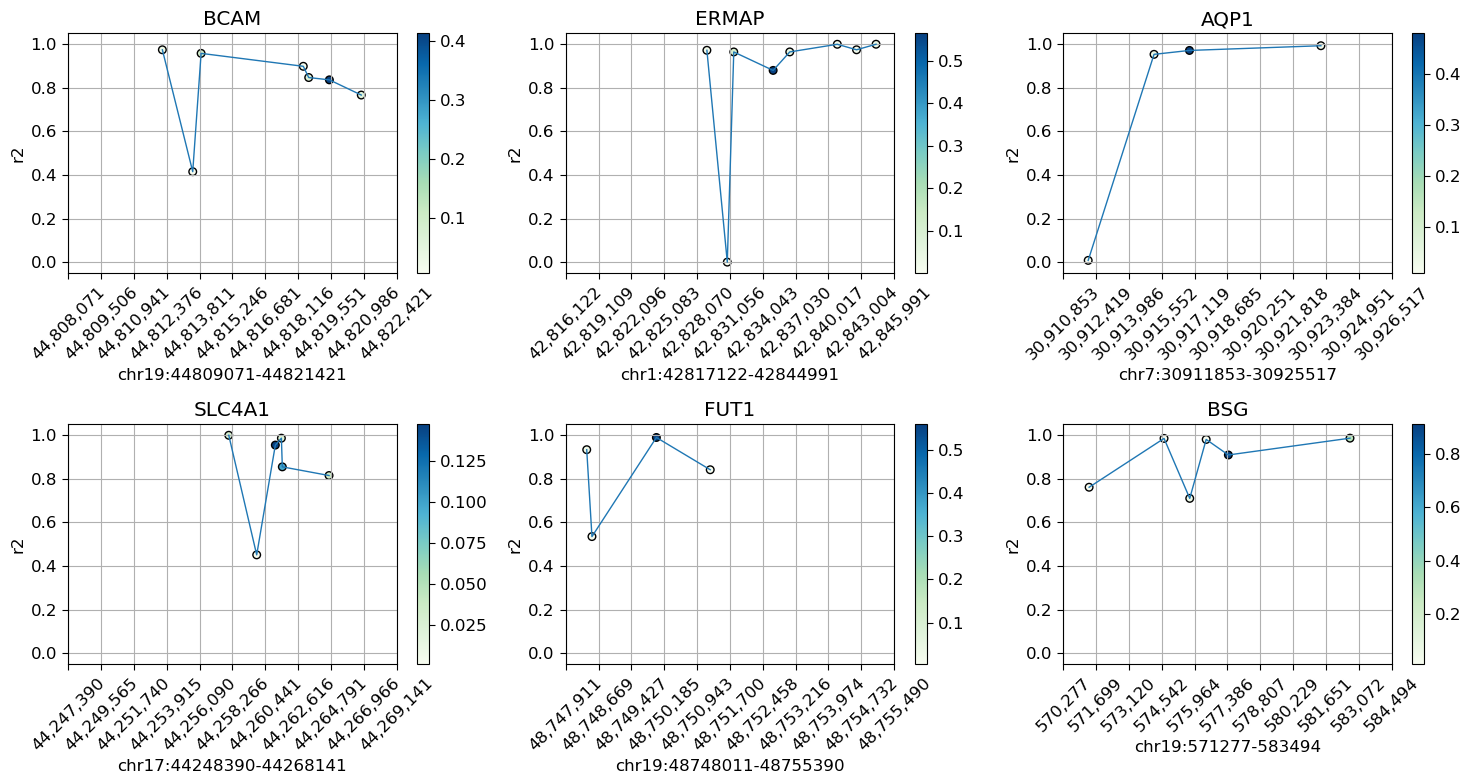

In [95]:
filtered_region = region[region['r2'] != 0]
filtered_region = filtered_region[filtered_region['r2'] < 0.9].reset_index(drop = True)

ngraph = len(filtered_region)
ncol = 3
nrow = ngraph//ncol
fig, axes = plt.subplots(nrow, ncol, figsize=(15,8))

for i in range(nrow*ncol):
    row = i // (nrow + 1)
    col = i % ncol
    if i < ngraph:
        c, s, e, t = filtered_region.iloc[i, :4]
        lcwgsus.plot_imputation_metric_in_region(h, chr=c, pos=0, start=s, end=e, title=t, show_fig=True, ax=axes[row, col])
    else:
        fig.delaxes(axes[row, col])
        
plt.tight_layout()
plt.show()

In [20]:
imp_dir = 'results/imputation_comparison/vanilla/lc_oneKG--chip--typed/impacc/all_samples/by_variant/'
hs = []
cs = [8,9,11]
for i in CHROMOSOMES_ALL:
    t = pd.read_csv(imp_dir + 'chr' + str(i) + '.h.tsv', sep = '\t')
    hs.append(t)
h = pd.concat(hs)
# h = h[(h[['NRC', 'r2', 'ccd_het', 'ccd_homalt']] != -9.).any(axis = 1)]

x = pd.merge(variants, h[COMMON_COLS + ['r2']], on = COMMON_COLS, how = 'left')
x

,chr,pos,ID,ref,alt,MAF,r2
0,11,5227002,rs334,T,A,0.04940,0.947045
1,11,5227003,rs33930165,C,T,0.01452,-9.000000
2,9,133257521,rs8176719,T,TC,0.30300,NaN
3,8,697972,rs1075451,C,T,0.57430,NaN


## two-stage TOPMed (N=8)

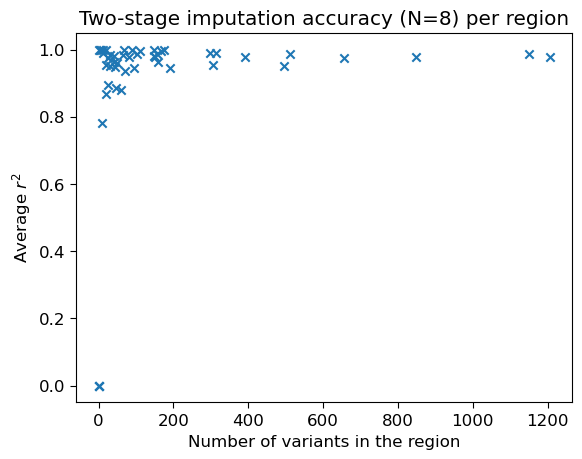

In [41]:
# imp_dir = '../archive/GAMCC_old/imputation_comparison/vanilla/lc_oneKG_topmed--hc--snps_gw/impacc/all_samples/by_variant/'
# hs = []
# for i in CHROMOSOMES_ALL:
#     t = pd.read_csv(imp_dir + 'chr' + str(i) + '.h.tsv', sep = '\t')
#     hs.append(t)
# h = pd.concat(hs)
# # h = h[(h[['NRC', 'r2', 'ccd_het', 'ccd_homalt']] != -9.).any(axis = 1)]
# h = h[h['r2'] != -9]

region = genes.copy()

region['r2'] = 0
region['n_variants'] = 0
# region['rho_variants'] = 0 # Density
for i in range(len(genes)):
    c,s,e,t = region.iloc[i, :4]
    tmp = h[h['chr'] == c]
    tmp = tmp[tmp['r2'] != -9]

    df = tmp[(tmp['pos'] < e) & (tmp['pos'] > s)]
    if len(df) == 0:
        pass
    else:
        region.loc[i, 'r2'] = df['r2'].mean()
        region.loc[i, 'n_variants'] = len(df)
#         region['rho_variants'] = 1000*len(df)/(e-s)

plt.scatter(region['n_variants'], region['r2'], marker = 'x')
plt.xlabel('Number of variants in the region')
plt.ylabel('Average $r^2$')
plt.title('Two-stage imputation accuracy (N=8) per region')
plt.show()

In [42]:
region.sort_values(by = 'r2')

,chr,start,end,gene,r2,n_variants
23,6,31982057,32002681,C4A,0.000000,0
10,6,32014795,32035418,C4B,0.000000,0
7,1,25272393,25330445,RHD,0.000000,0
16,1,3772749,3775982,SMIM1,0.782069,8
12,19,5842888,5851471,FUT3,0.866521,19
36,9,133152948,133163933,GBGT1,0.879873,61
13,7,30911853,30925517,AQP1,0.886378,46
40,20,4686350,4701590,PRNP,0.893519,24
26,19,571277,583494,BSG,0.937023,70
34,19,10602457,10644557,SLC44A2,0.945755,95


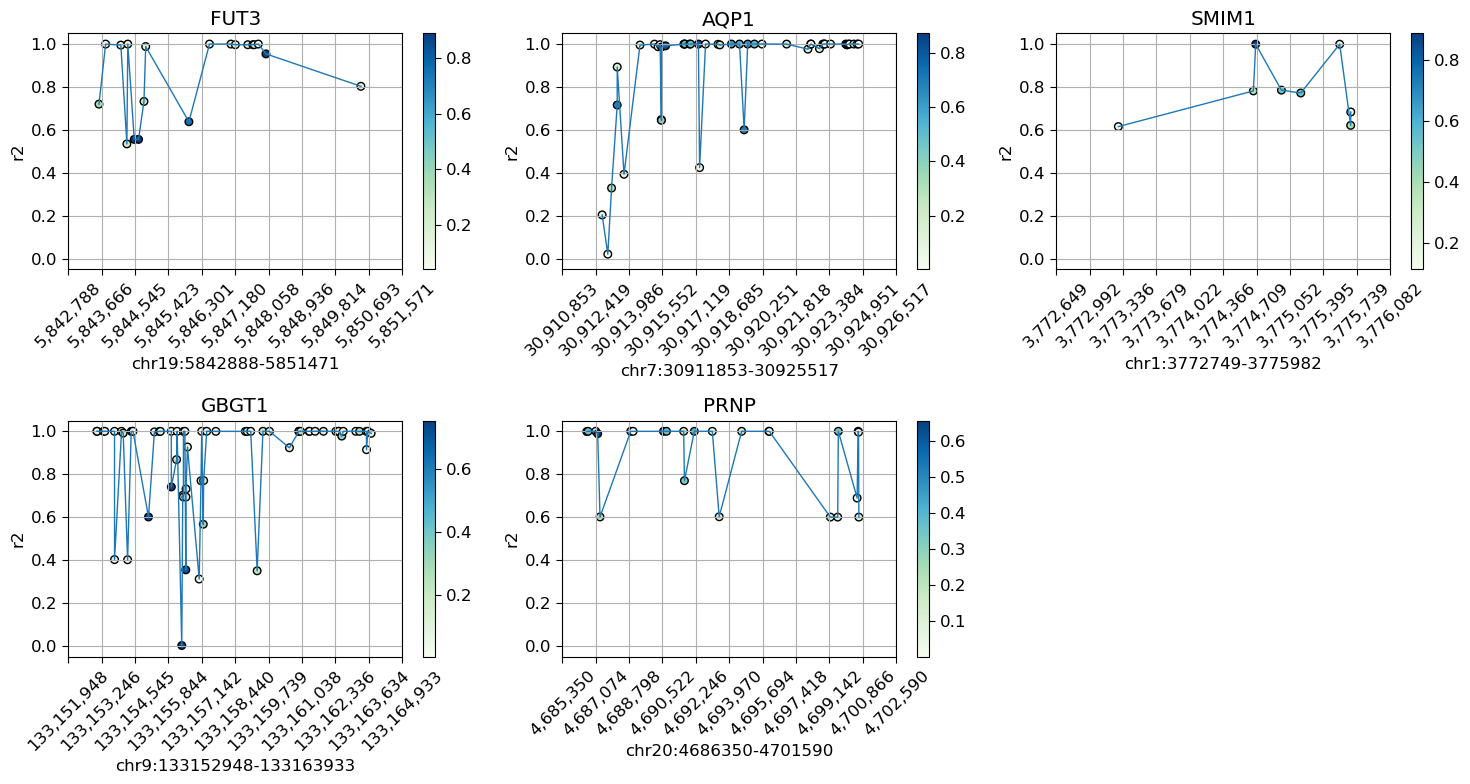

In [46]:
filtered_region = region[region['r2'] != 0]
filtered_region = filtered_region[filtered_region['r2'] < 0.9].reset_index(drop = True)

ngraph = len(filtered_region)
ncol = 3
nrow = ngraph//ncol + 1
fig, axes = plt.subplots(nrow, ncol, figsize=(15,8))

for i in range(nrow*ncol):
    row = i // (nrow + 1)
    col = i % ncol
    if i < ngraph:
        c, s, e, t = filtered_region.iloc[i, :4]
        lcwgsus.plot_imputation_metric_in_region(h, chr=c, pos=0, start=s, end=e, title=t, show_fig=True, ax=axes[row, col])
    else:
        fig.delaxes(axes[row, col])
        
plt.tight_layout()
plt.show()

In [19]:
imp_dir = 'results/imputation_comparison/vanilla/lc_oneKG_topmed--hc--snps_gw/impacc/all_samples/by_variant/'
# imp_dir = '../archive/GAMCC_old/imputation_comparison/vanilla/lc_oneKG_topmed--hc--snps_gw/impacc/all_samples/by_variant/'
hs = []
cs = [8,9,11]
for i in cs:
    t = pd.read_csv(imp_dir + 'chr' + str(i) + '.h.tsv', sep = '\t')
    hs.append(t)
h = pd.concat(hs)
# h = h[(h[['NRC', 'r2', 'ccd_het', 'ccd_homalt']] != -9.).any(axis = 1)]
h = h[h['r2'] != -9]

x = pd.merge(variants, h[COMMON_COLS + ['r2']], on = COMMON_COLS, how = 'left')
x

,chr,pos,ID,ref,alt,MAF,r2
0,11,5227002,rs334,T,A,0.04940,NaN
1,11,5227003,rs33930165,C,T,0.01452,NaN
2,9,133257521,rs8176719,T,TC,0.30300,0.999990
3,8,697972,rs1075451,C,T,0.57430,0.999984


# Examine BEAGLE phasing missing HLA types

In [32]:
study = '1KG'
gene = 'A'
vcf = lcwgsus.read_vcf(f'results/phasing/HLA_{study}_BEAGLE/tmp/phased.{gene}.{study}.chr6.vcf.gz')
samples = vcf.columns[9:].tolist()
vcf = vcf.drop(columns = ['chr', 'pos', 'ref', 'alt', 'QUAL', 'FILTER', 'INFO', 'FORMAT']).reset_index(drop = True).T

beagle_hla = pd.DataFrame({'Sample ID': samples})
beagle_hla[f'HLA-{gene} 1'] = 'N/A'
beagle_hla[f'HLA-{gene} 2'] = 'N/A'

In [54]:
study = '1KG'
gene = 'A'
vcf = lcwgsus.read_vcf(f'results/phasing/HLA_{study}_BEAGLE/tmp/phased.{gene}.{study}.chr6.vcf.gz')
samples = vcf.columns[9:].tolist()
vcf = vcf.drop(columns = ['chr', 'pos', 'ref', 'alt', 'QUAL', 'FILTER', 'INFO', 'FORMAT']).reset_index(drop = True).T

beagle_hla = pd.DataFrame({'Sample ID': samples})
beagle_hla[f'HLA-{gene} 1'] = 'N/A'
beagle_hla[f'HLA-{gene} 2'] = 'N/A'

for i,s in enumerate(samples):
    vcf_row = vcf.loc[s, :]
    alleles_idx = vcf_row.index[vcf_row.str.contains('1')]
    if len(alleles_idx) != 0:
        if (len(alleles_idx) == 2) and (vcf.loc[s,alleles_idx[0]] == vcf.loc[s,alleles_idx[1]]): # Means beagle phase the two HLA alleles to one haplotype
            pass
        else:
            for j in alleles_idx:
                name = vcf.loc['ID',j]
                genotype = vcf.loc[s,j]
                twofield = name.split('*')[1]
                if genotype == '1|0':
                    beagle_hla.loc[i, f'HLA-{gene} 1'] = twofield
                elif genotype == '0|1':
                    beagle_hla.loc[i, f'HLA-{gene} 2'] = twofield
                elif genotype == '1|1':
                    beagle_hla.loc[i, f'HLA-{gene} 1'] = twofield
                    beagle_hla.loc[i, f'HLA-{gene} 2'] = twofield
                else:
                    pass
beagle_hla

,Sample ID,HLA-A 1,HLA-A 2
0,HG00096,01:01,29:02
1,HG00097,24:02,03:01
2,HG00099,01:01,68:01
3,HG00100,01:01,01:01
4,HG00101,11:01,32:01
...,...,...,...
2563,NA21137,01:01,11:01
2564,NA21141,24:02,02:11
2565,NA21142,24:02,03:01
2566,NA21143,11:01,26:01


In [55]:
beagle_hla[beagle_hla['Sample ID'] == 'HG02299']

,Sample ID,HLA-A 1,HLA-A 2
888,HG02299,N/A,N/A


# Generate GAMCC sample files from PCs

In [19]:
output = "results/gwas/mGenv1_topmed/vcf/blood_groups.sample"

metadata = pd.read_csv('data/metadata/GAMCC-lcWGS_metadata.csv')
metadata = metadata[['anon_id', 'Status_v1']]
fv_gam_names = lcwgsus.read_tsv_as_lst('data/sample_tsvs/fv_gam_names.tsv')
metadata = metadata[metadata['anon_id'].isin(fv_gam_names)]
metadata.columns = ['ID', 'malaria']
metadata['malaria'] = metadata['malaria'].map({'Mild malaria': 'mild', 'Non-malaria control': 'control', 'Severe malaria': 'severe'})
metadata = metadata.reset_index(drop = True)

n_PCs = 4
PCs = pd.read_csv('results/wip_vcfs/oneKG/vanilla/chip_sites/PCs.eigenvec', sep = ' ', header = None)
PCs = PCs.iloc[:,1:(n_PCs + 2)]
PCs.columns = ['ID'] + [f'PC{i}' for i in range(1,(n_PCs + 1))]
for c in PCs.columns[1:]:
    PCs[c] = PCs[c].astype(str)

sample = pd.merge(metadata, PCs, on = 'ID')
sample.loc[-1] = ['0', 'D', 'C', 'C', 'C', 'C']
sample.index = sample.index + 1  # Shift the index up
sample = sample.sort_index()
sample.to_csv(output, sep = ' ', index = False, header = True)

# GWAS

## Multinomial Logistic Regression

In [36]:
def plot_gwas_sumstat_col(annot, col = 'frequentist_gen_lrt_pvalue', title = ''):
    data = annot[['rsid', 'region', 'chromosome', 'position', col]]
    data.columns = ['SNP', 'Region', 'CHR', 'BP', 'P']

    data['-log10(P)'] = -np.log10(data['P'])
    data = data.sort_values(['CHR', 'BP'], ascending = True).reset_index(drop=True)
    data['cumulative_BP'] = 0

    gap = 30000
    tmp_max_idx = 0

    tmp_lst = []
    for region, region_data in data.groupby('Region', sort = False):
        region_data = region_data.copy()
        region_data['BP'] = region_data['BP'] - region_data['BP'].min() + tmp_max_idx + gap
        tmp_max_idx = region_data['BP'].max()
        tmp_lst.append(region_data)

    data = pd.concat(tmp_lst)
    significance_threshold = -np.log10(5e-8)

    plt.figure(figsize=(12, 6))
    colors = ['#1076ae', '#60c1f6']
    for i, (region_name, region_data) in enumerate(data.groupby('Region', sort = False)):
        plt.scatter(
            region_data['BP'], region_data['-log10(P)'],
            c=colors[i % 2], s=10, label=region_name if i < 2 else None
        )

    xticks = []
    xlabels = []
    for region, region_data in data.groupby('Region', sort = False):
        middle = region_data['BP'].median()
        xticks.append(middle)
        xlabels.append(region)

    plt.xticks(ticks=xticks, labels=xlabels, fontsize=10, rotation=90)
    plt.xlabel('Genes', fontsize=12)
    plt.ylabel('-log10(P)', fontsize=12)
    plt.title(title)

    plt.tight_layout()
    plt.show()

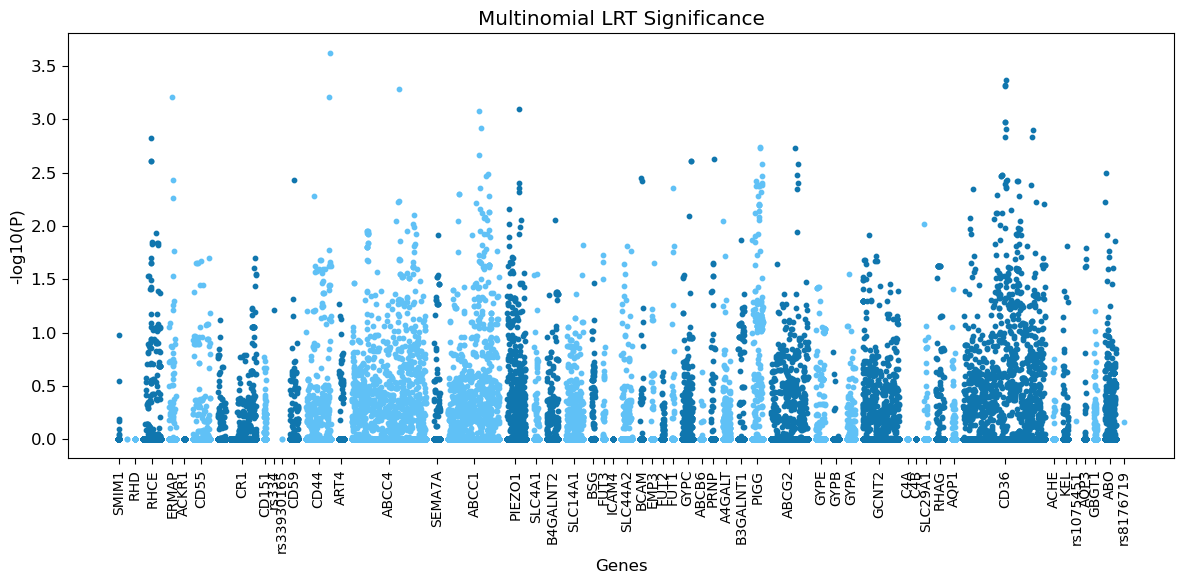

In [37]:
sumstat = pd.read_csv('results/gwas/mGenv1_topmed/mlr/results/stats.out', sep = '\t', comment = '#')

genes = pd.read_csv('data/blood_group_variants/blood_group_genes.tsv', sep = '\t', index_col = False)
genes = genes[genes['Chromosome'] != 'X'].reset_index(drop = True)
genes = genes.iloc[:,[1,2,3,0]]
genes.columns = ['chr', 'start', 'end', 'gene']
genes['chr'] = genes['chr'].astype(int)
genes.loc[len(genes)] = [11, '5227002', '5227002', 'rs334']
genes.loc[len(genes)] = [11, '5227003', '5227003', 'rs33930165']
genes.loc[len(genes)] = [9, '133257521', '133257521', 'rs8176719']
genes.loc[len(genes)] = [8, '697972', '697972', 'rs1075451']
genes['start'] = genes['start'].astype(int)
genes['end'] = genes['end'].astype(int)
genes = genes.sort_values(by = ['chr', 'start'], ascending = True).reset_index(drop = True)

for i in range(len(genes)):
    c, s, e, g = tuple(genes.iloc[i,:])
    tmp = sumstat[(sumstat['chromosome'] == f'chr{c}') & (sumstat['position'] <= e) & (sumstat['position'] >= s)]
    tmp['region'] = g
    
    if i == 0:
        annot = tmp
    else:
        annot = pd.concat([annot, tmp])
annot = annot.fillna(1)

plot_gwas_sumstat_col(annot, title = 'Multinomial LRT Significance')

In [38]:
annot[annot['rsid'].isin(['rs334'])]

,alternate_ids,rsid,chromosome,position,alleleA,alleleB,incorrectly_coded,all_A,all_B,all_AA,...,frequentist_gen_wald_pvalue_1,frequentist_gen_wald_pvalue_2,frequentist_gen_wald_pvalue_4,frequentist_gen_wald_pvalue_5,frequentist_gen_degrees_of_freedom,frequentist_gen_lrt_pvalue,frequentist_gen_iterations,frequentist_gen_fit_time,comment,region
191448,rs334,rs334,chr11,5227002,T,A,1.0,0,0,186.988,...,0.802762,0.846282,0.18455,0.961922,4.0,0.061733,7.0,0.0,1,rs334


## Logistic Regression (Case = mild+severe, Control = control)

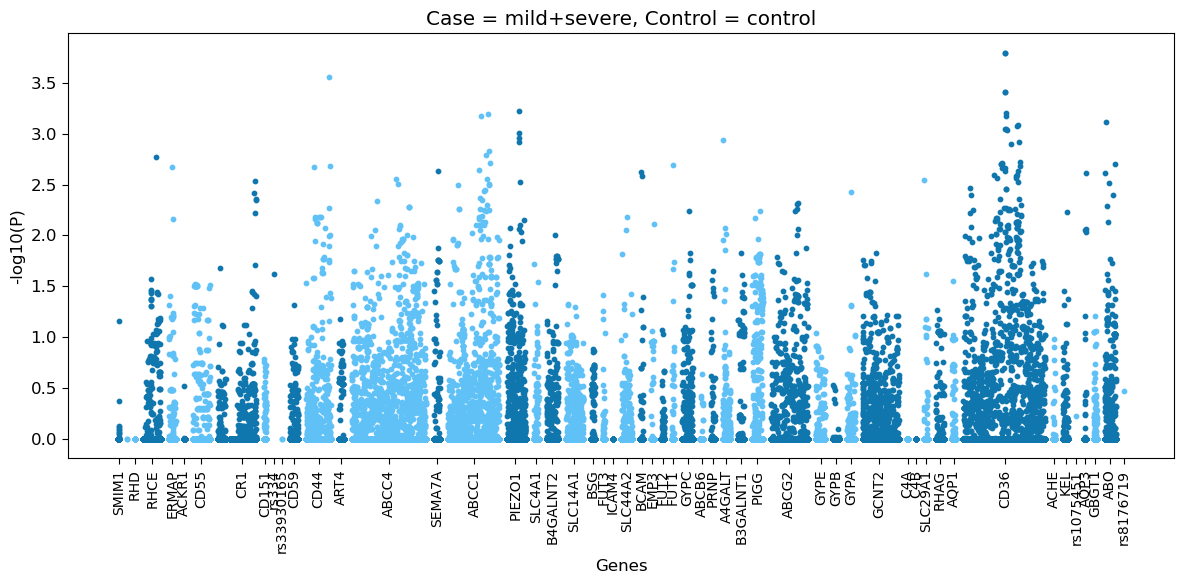

In [43]:
sumstat = pd.read_csv('results/gwas/mGenv1_topmed/lr1/results/stats.out', sep = '\t', comment = '#')

genes = pd.read_csv('data/blood_group_variants/blood_group_genes.tsv', sep = '\t', index_col = False)
genes = genes[genes['Chromosome'] != 'X'].reset_index(drop = True)
genes = genes.iloc[:,[1,2,3,0]]
genes.columns = ['chr', 'start', 'end', 'gene']
genes['chr'] = genes['chr'].astype(int)
genes.loc[len(genes)] = [11, '5227002', '5227002', 'rs334']
genes.loc[len(genes)] = [11, '5227003', '5227003', 'rs33930165']
genes.loc[len(genes)] = [9, '133257521', '133257521', 'rs8176719']
genes.loc[len(genes)] = [8, '697972', '697972', 'rs1075451']
genes['start'] = genes['start'].astype(int)
genes['end'] = genes['end'].astype(int)
genes = genes.sort_values(by = ['chr', 'start'], ascending = True).reset_index(drop = True)

for i in range(len(genes)):
    c, s, e, g = tuple(genes.iloc[i,:])
    tmp = sumstat[(sumstat['chromosome'] == f'chr{c}') & (sumstat['position'] <= e) & (sumstat['position'] >= s)]
    tmp['region'] = g
    
    if i == 0:
        annot = tmp
    else:
        annot = pd.concat([annot, tmp])
annot = annot.fillna(1)
annot = annot[annot['frequentist_gen_wald_pvalue_1'] > 1e-50]

plot_gwas_sumstat_col(annot, title = 'Case = mild+severe, Control = control')

In [44]:
annot[annot['rsid'].isin(['rs334'])]

,alternate_ids,rsid,chromosome,position,alleleA,alleleB,incorrectly_coded,all_A,all_B,all_AA,...,frequentist_gen_se_2,"frequentist_gen_cov_1,2",frequentist_gen_wald_pvalue_1,frequentist_gen_wald_pvalue_2,frequentist_gen_degrees_of_freedom,frequentist_gen_lrt_pvalue,frequentist_gen_iterations,frequentist_gen_fit_time,comment,region
191448,rs334,rs334,chr11,5227002,T,A,1.0,0,0,186.988,...,0.73604,-0.306109,0.050179,0.710242,2.0,0.024061,2.0,0.0,1,rs334


## Logistic Regression (Case = severe, Control = control + mild)

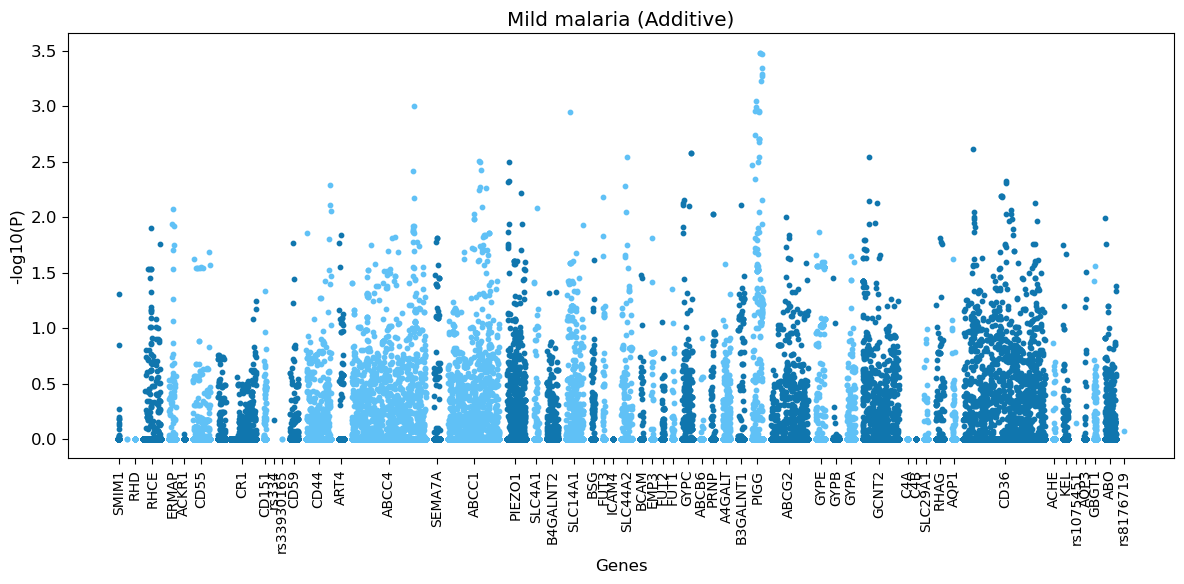

In [45]:
sumstat = pd.read_csv('results/gwas/mGenv1_topmed/lr2/results/stats.out', sep = '\t', comment = '#')

genes = pd.read_csv('data/blood_group_variants/blood_group_genes.tsv', sep = '\t', index_col = False)
genes = genes[genes['Chromosome'] != 'X'].reset_index(drop = True)
genes = genes.iloc[:,[1,2,3,0]]
genes.columns = ['chr', 'start', 'end', 'gene']
genes['chr'] = genes['chr'].astype(int)
genes.loc[len(genes)] = [11, '5227002', '5227002', 'rs334']
genes.loc[len(genes)] = [11, '5227003', '5227003', 'rs33930165']
genes.loc[len(genes)] = [9, '133257521', '133257521', 'rs8176719']
genes.loc[len(genes)] = [8, '697972', '697972', 'rs1075451']
genes['start'] = genes['start'].astype(int)
genes['end'] = genes['end'].astype(int)
genes = genes.sort_values(by = ['chr', 'start'], ascending = True).reset_index(drop = True)

for i in range(len(genes)):
    c, s, e, g = tuple(genes.iloc[i,:])
    tmp = sumstat[(sumstat['chromosome'] == f'chr{c}') & (sumstat['position'] <= e) & (sumstat['position'] >= s)]
    tmp['region'] = g
    
    if i == 0:
        annot = tmp
    else:
        annot = pd.concat([annot, tmp])
annot = annot.fillna(1)
annot = annot[annot['frequentist_gen_wald_pvalue_1'] > 1e-50]

plot_gwas_sumstat_col(annot, title = 'Case = severe, Control = control + mild')

In [46]:
annot[annot['rsid'].isin(['rs334'])]

,alternate_ids,rsid,chromosome,position,alleleA,alleleB,incorrectly_coded,all_A,all_B,all_AA,...,frequentist_gen_se_2,"frequentist_gen_cov_1,2",frequentist_gen_wald_pvalue_1,frequentist_gen_wald_pvalue_2,frequentist_gen_degrees_of_freedom,frequentist_gen_lrt_pvalue,frequentist_gen_iterations,frequentist_gen_fit_time,comment,region
191448,rs334,rs334,chr11,5227002,T,A,1.0,0,0,186.988,...,0.772576,-0.306048,0.516804,0.942257,2.0,0.678656,2.0,0.0,1,rs334


## Logistic Regression (Case = severe, Control = control)

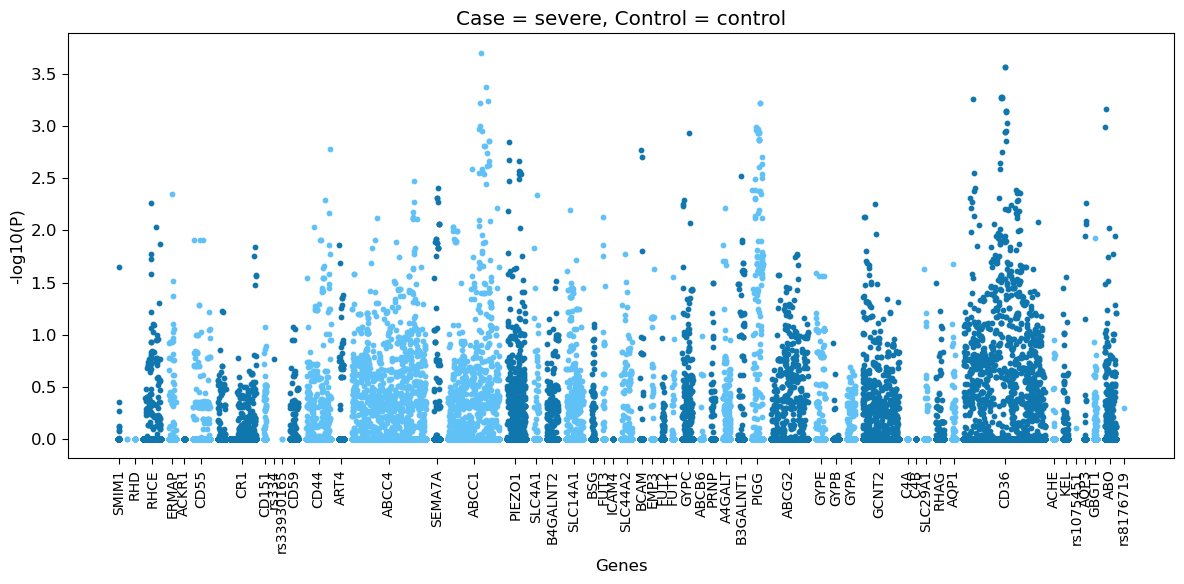

In [50]:
sumstat = pd.read_csv('results/gwas/mGenv1_topmed/lr3/results/stats.out', sep = '\t', comment = '#')

genes = pd.read_csv('data/blood_group_variants/blood_group_genes.tsv', sep = '\t', index_col = False)
genes = genes[genes['Chromosome'] != 'X'].reset_index(drop = True)
genes = genes.iloc[:,[1,2,3,0]]
genes.columns = ['chr', 'start', 'end', 'gene']
genes['chr'] = genes['chr'].astype(int)
genes.loc[len(genes)] = [11, '5227002', '5227002', 'rs334']
genes.loc[len(genes)] = [11, '5227003', '5227003', 'rs33930165']
genes.loc[len(genes)] = [9, '133257521', '133257521', 'rs8176719']
genes.loc[len(genes)] = [8, '697972', '697972', 'rs1075451']
genes['start'] = genes['start'].astype(int)
genes['end'] = genes['end'].astype(int)
genes = genes.sort_values(by = ['chr', 'start'], ascending = True).reset_index(drop = True)

for i in range(len(genes)):
    c, s, e, g = tuple(genes.iloc[i,:])
    tmp = sumstat[(sumstat['chromosome'] == f'chr{c}') & (sumstat['position'] <= e) & (sumstat['position'] >= s)]
    tmp['region'] = g
    
    if i == 0:
        annot = tmp
    else:
        annot = pd.concat([annot, tmp])
annot = annot.fillna(1)
annot = annot[annot['frequentist_gen_wald_pvalue_1'] > 1e-50]

plot_gwas_sumstat_col(annot, title = 'Case = severe, Control = control')

In [52]:
annot[annot['rsid'].isin(['rs334'])]

,alternate_ids,rsid,chromosome,position,alleleA,alleleB,incorrectly_coded,all_A,all_B,all_AA,...,frequentist_gen_se_2,"frequentist_gen_cov_1,2",frequentist_gen_wald_pvalue_1,frequentist_gen_wald_pvalue_2,frequentist_gen_degrees_of_freedom,frequentist_gen_lrt_pvalue,frequentist_gen_iterations,frequentist_gen_fit_time,comment,region
187003,rs8176719,rs8176719,chr9,133257521,T,TC,1.0,0,0,56.8668,...,0.374268,-0.035719,0.781799,0.336225,2.0,0.499915,1.0,0.0,1,ABO
187003,rs8176719,rs8176719,chr9,133257521,T,TC,1.0,0,0,56.8668,...,0.374268,-0.035719,0.781799,0.336225,2.0,0.499915,1.0,0.0,1,rs8176719
191448,rs334,rs334,chr11,5227002,T,A,1.0,0,0,120.9920,...,0.795341,-0.302378,0.186072,0.966759,2.0,0.171451,2.0,0.0,1,rs334
